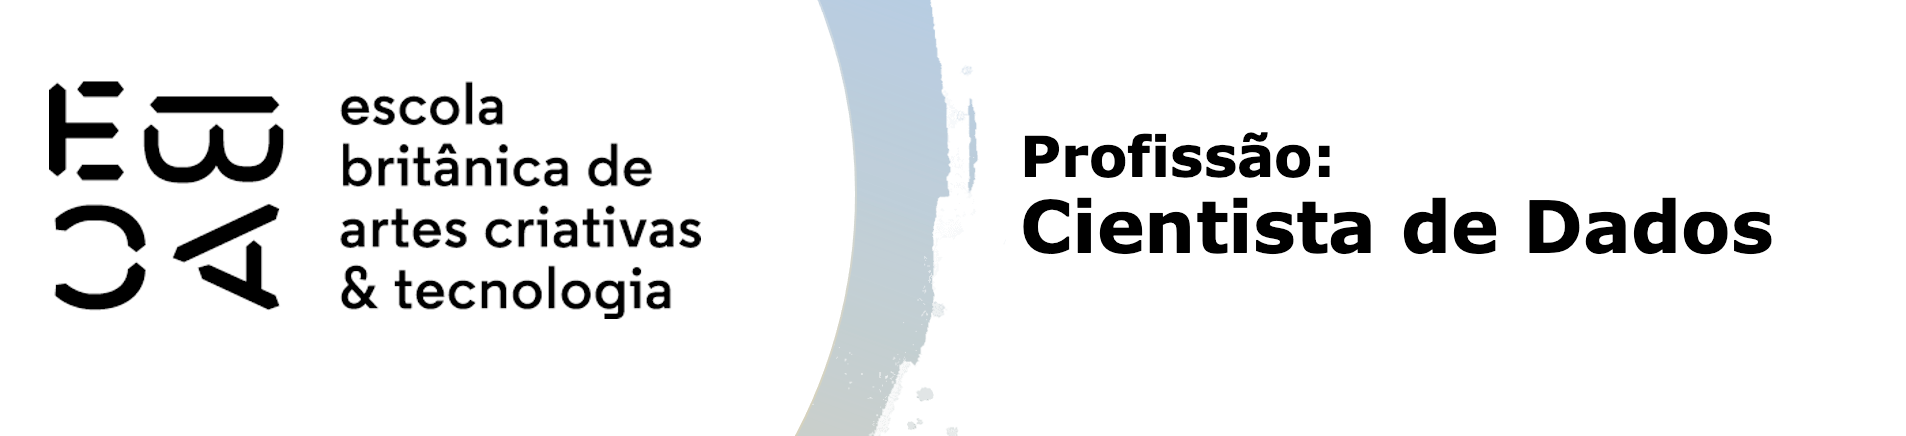

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [122]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm
plt.style.use('ggplot')

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.read_feather('./data/credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Functions used:

In [124]:
def univ_plot(df, threshold=15, categorical=True, log=False):
    import random
    import numpy as np
    
    # Determine categorical and continuous columns
    categorical_columns = [col for col in df.columns if df[col].nunique() <= threshold]
    continuous_columns = [col for col in df.columns if df[col].nunique() > threshold]
    
    if categorical:
        # Plot categorical variables
        num_plots = len(categorical_columns)
        if num_plots == 0:
            print("No categorical variables to plot.")
            return
        fig, axes = plt.subplots(nrows=(num_plots // 2) + (num_plots % 2), ncols=2, figsize=(20, 5 * ((num_plots // 2) + (num_plots % 2))))
        axes = axes.flatten()
        
        for ax, col in zip(axes, categorical_columns):
            plot = sns.countplot(x=col, data=df, hue=col, legend=False, ax=ax)
            ax.set_title(f'Count of {col}', fontsize=20)
            ax.set_xlabel(col, fontsize=18)
            ax.set_ylabel('Count', fontsize=18)
            ax.tick_params(axis='x', rotation=45, labelsize=16)
            ax.tick_params(axis='y', labelsize=16)
            
            # Annotate each bar with the count if the variable has 10 or fewer categories
            if df[col].nunique() <= 10:
                for p in plot.patches:
                    plot.annotate(format(p.get_height(), '.0f'), 
                                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                                  ha = 'center', va = 'center', 
                                  xytext = (0, 9), 
                                  textcoords = 'offset points',
                                  fontsize=14)
        
        # Hide any remaining axes if the number of plots is odd
        for i in range(num_plots, len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.show()
    else:
        # Define a list of colors
        colors = [
            '#1f77b4', '#ff7f0e', '#2ca02c', 
            '#d62728', '#9467bd', '#8c564b', 
            '#e377c2', '#7f7f7f', '#bcbd22', 
            '#17becf'
        ]
        
        # Plot continuous variables
        num_plots = len(continuous_columns)
        if num_plots == 0:
            print("No continuous variables to plot.")
            return
        fig, axes = plt.subplots(nrows=(num_plots // 2) + (num_plots % 2), ncols=2, figsize=(20, 5 * ((num_plots // 2) + (num_plots % 2))))
        axes = axes.flatten()
        
        for ax, col in zip(axes, continuous_columns):
            data = np.log(df[col]) if log else df[col]
            color = random.choice(colors)
            sns.violinplot(y=data, ax=ax, color=color)
            ax.set_title(f'Violin Plot of {col}', fontsize=20)
            ax.set_ylabel(col, fontsize=18)
            ax.tick_params(axis='y', labelsize=16)
        
        # Hide any remaining axes if the number of plots is odd
        for i in range(num_plots, len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.show()

In [125]:
def biv_plot(df, x, y, threshold=15, sample_size=500):
    from statsmodels.graphics.mosaicplot import mosaic
    # Determine if the variables are categorical or continuous
    x_is_categorical = df[x].nunique() <= threshold
    y_is_categorical = df[y].nunique() <= threshold

    plt.figure(figsize=(10, 6))

    if not x_is_categorical and not y_is_categorical:
        # Scenario 1: Continuous x Continuous
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Sample for scatter plot if dataset is large
        if len(df) > sample_size:
            df_sampled = df.sample(sample_size)
        else:
            df_sampled = df
        
        sns.regplot(x=x, y=y, data=df_sampled, ax=ax, scatter_kws={'s': 50, 'alpha': 0.5}, line_kws={'color': 'red'}) # Scatter Plot with Regression Line
        ax.set_title(f'Scatter Plot with Regression Line: {x} vs {y}')
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        
        plt.tight_layout()
        plt.show()

    elif x_is_categorical and not y_is_categorical:
        # Scenario 2: Continuous x Categorical
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))

        sns.boxplot(x=x, y=y, data=df, ax=axs[0, 0], hue=x) # Box Plot
        axs[0, 0].set_title('Box Plot')
        axs[0, 0].tick_params(axis='x', rotation=45)

        sns.violinplot(x=x, y=y, data=df, ax=axs[0, 1], hue=x) # Violin Plot
        axs[0, 1].set_title('Violin Plot')
        axs[0, 1].tick_params(axis='x', rotation=45)

        sns.stripplot(x=x, y=y, data=df, jitter=True, ax=axs[1, 0], hue=x) # Strip Plot
        axs[1, 0].set_title('Strip Plot')
        axs[1, 0].tick_params(axis='x', rotation=45)

        sns.barplot(x=x, y=y, data=df, ax=axs[1, 1], hue=x) # Bar Plot
        axs[1, 1].set_title('Bar Plot')
        axs[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    elif not x_is_categorical and y_is_categorical:
        # Scenario 2: Categorical x Continuous (swapped)
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))

        sns.boxplot(x=y, y=x, data=df, ax=axs[0, 0], hue=y) # Box Plot
        axs[0, 0].set_title('Box Plot')
        axs[0, 0].tick_params(axis='x', rotation=45)

        sns.violinplot(x=y, y=x, data=df, ax=axs[0, 1], hue=y) # Violin Plot
        axs[0, 1].set_title('Violin Plot')
        axs[0, 1].tick_params(axis='x', rotation=45)

        sns.stripplot(x=y, y=x, data=df, jitter=True, ax=axs[1, 0], hue=y) # Strip Plot
        axs[1, 0].set_title('Strip Plot')
        axs[1, 0].tick_params(axis='x', rotation=45)

        sns.barplot(x=y, y=x, data=df, ax=axs[1, 1], hue=y) # Bar Plot
        axs[1, 1].set_title('Bar Plot')
        axs[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    else:
        # Scenario 3: Categorical x Categorical
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))

        # Stacked Bar Chart
        crosstab = pd.crosstab(df[x], df[y])
        crosstab_perc = crosstab.div(crosstab.sum(1), axis=0)
        crosstab_perc.plot(kind='bar', stacked=True, ax=axs[0, 0])
        axs[0, 0].set_title('Stacked Bar Chart')
        axs[0, 0].tick_params(axis='x', rotation=45)

        # Add percentage labels on top of the bars for Stacked Bar Chart
        for container in axs[0, 0].containers:
            axs[0, 0].bar_label(container, labels=[f'{v * 100:.1f}%' for v in container.datavalues], label_type='center')

        # Grouped Bar Chart
        crosstab.plot(kind='bar', ax=axs[0, 1])
        axs[0, 1].set_title('Grouped Bar Chart')
        axs[0, 1].tick_params(axis='x', rotation=45)

        # Add values on top of the bars for Grouped Bar Chart
        for container in axs[0, 1].containers:
            axs[0, 1].bar_label(container)

        # Mosaic Plot
        mosaic(df, [x, y], ax=axs[1, 0])
        axs[1, 0].set_title('Mosaic Plot')
        axs[1, 0].tick_params(axis='x', rotation=45)

        # Count Plot
        sns.countplot(x=x, hue=y, data=df, ax=axs[1, 1])
        axs[1, 1].set_title('Count Plot')
        axs[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [127]:
df.drop(columns='index', inplace=True)
df['log_renda'] = np.log(df['renda'])

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

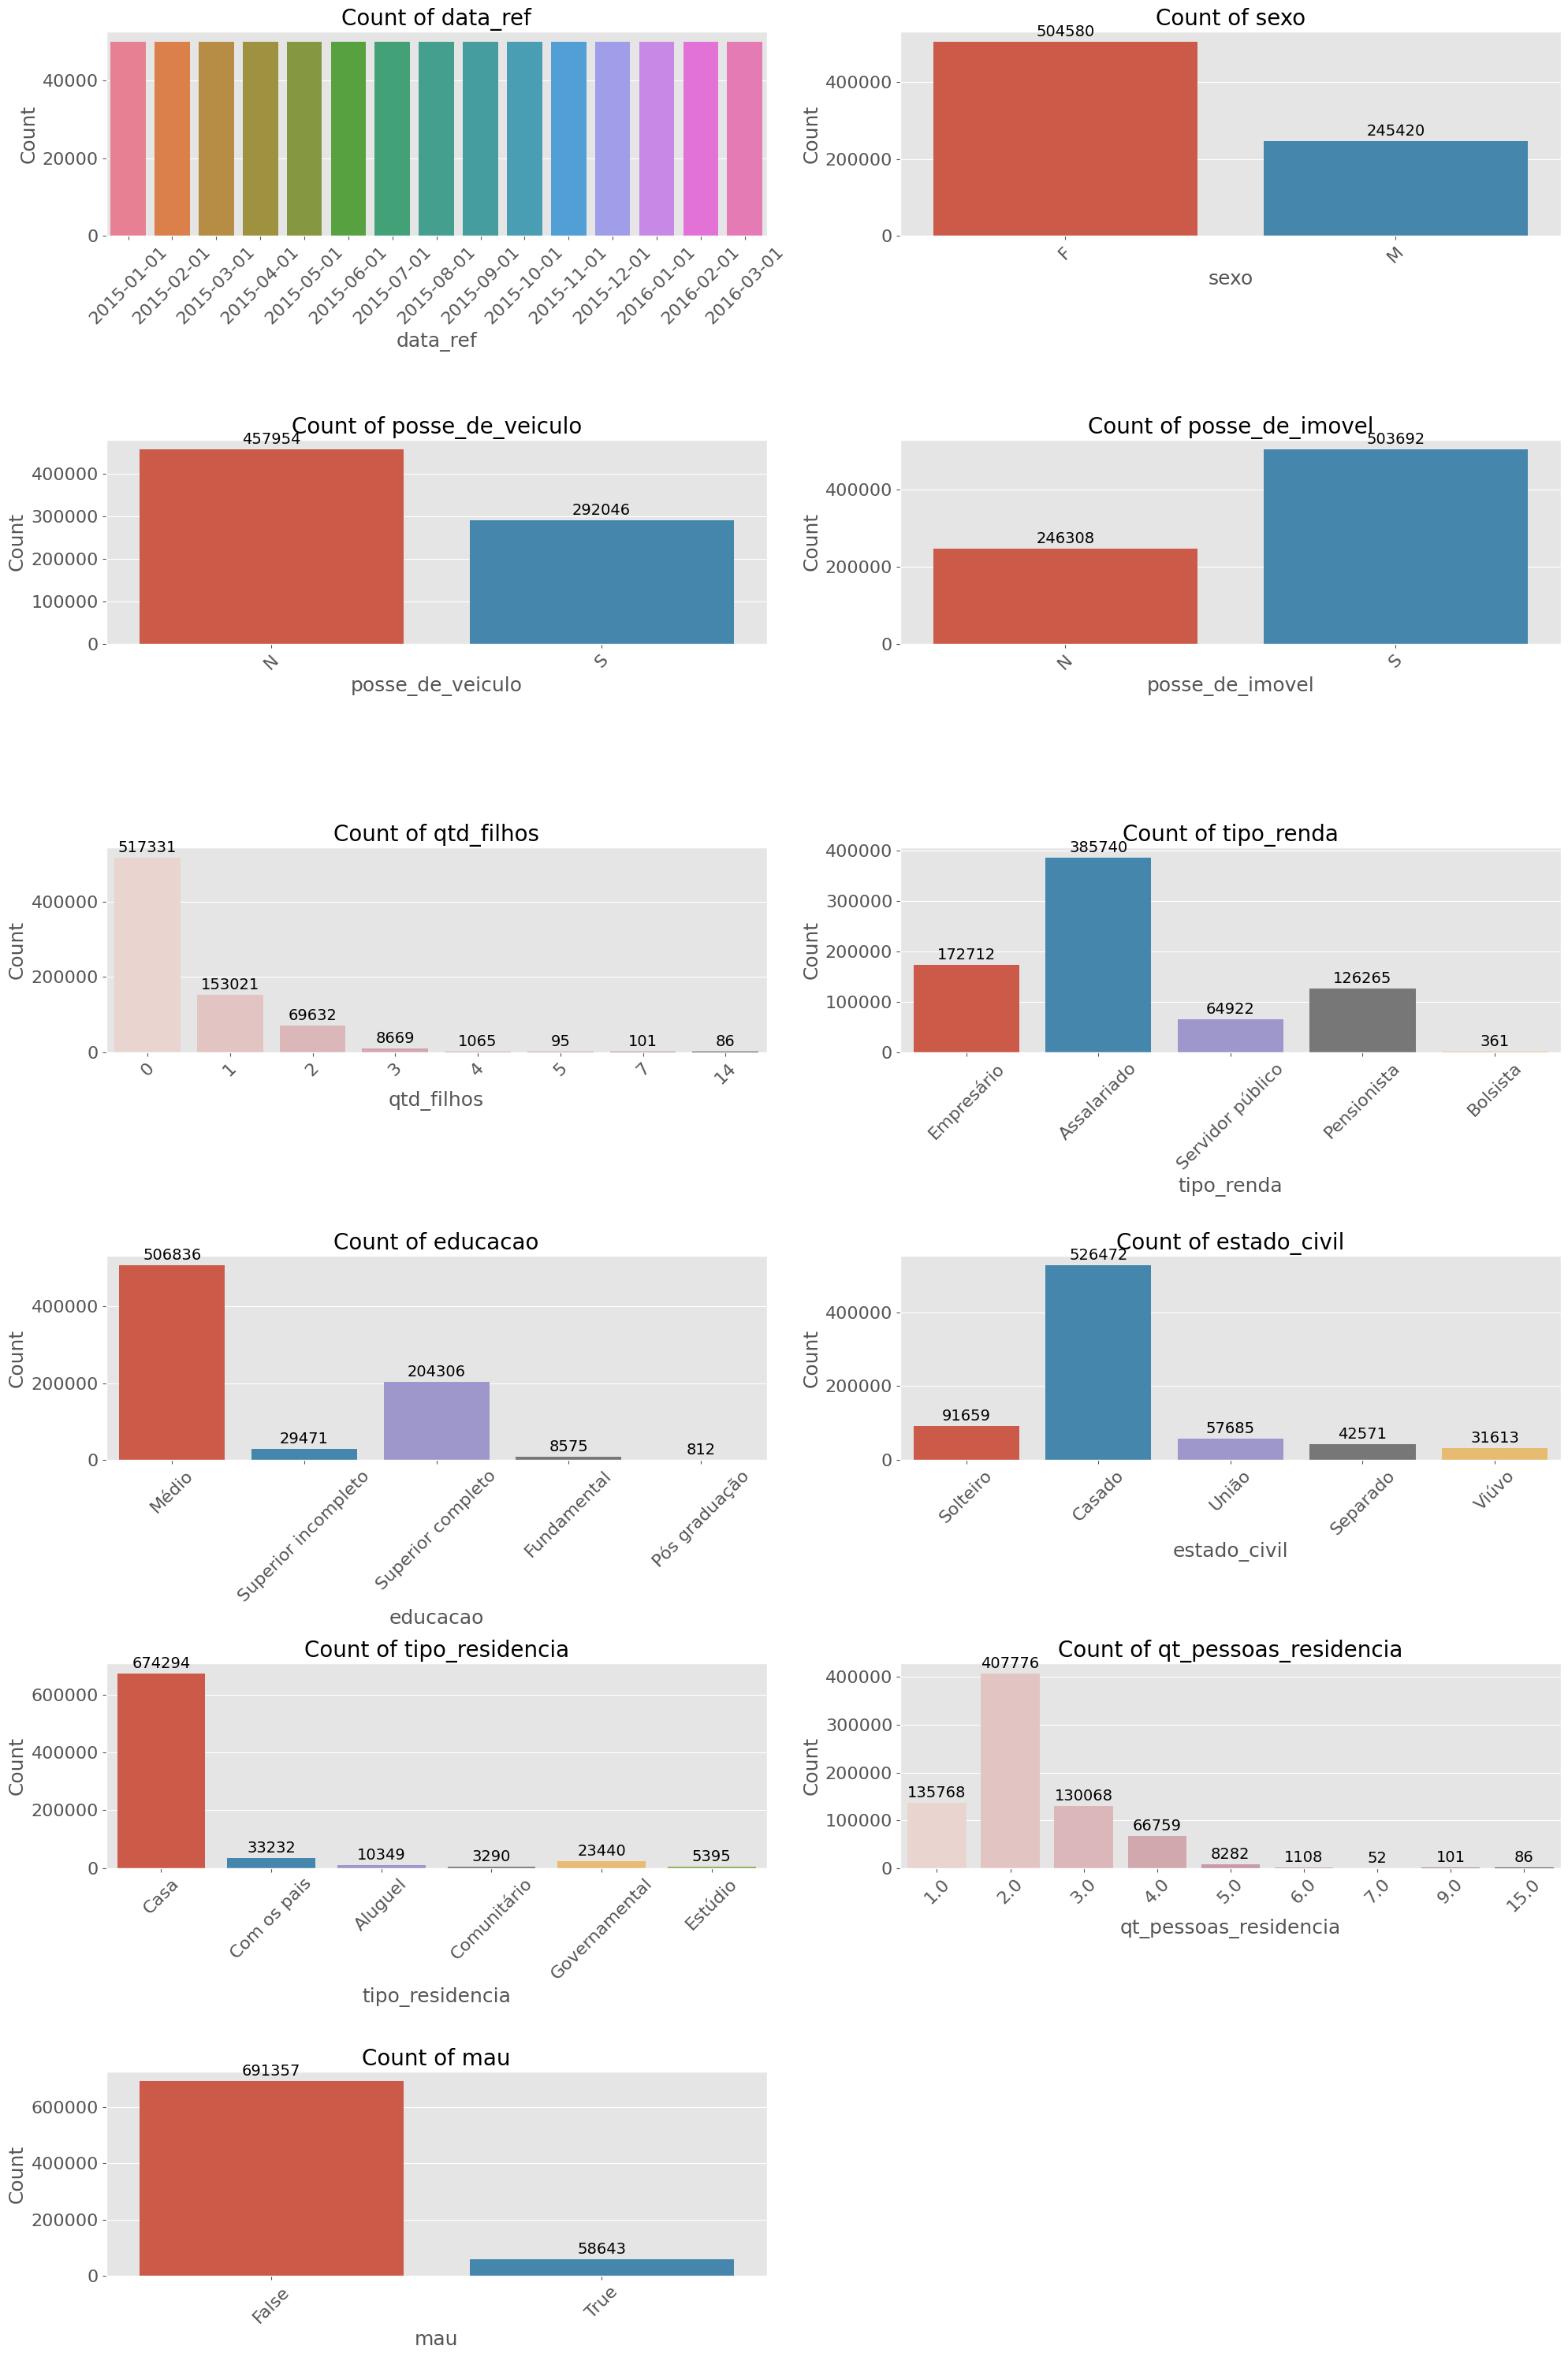

CPU times: total: 14.9 s
Wall time: 29.6 s


In [129]:
%%time

univ_plot(df)

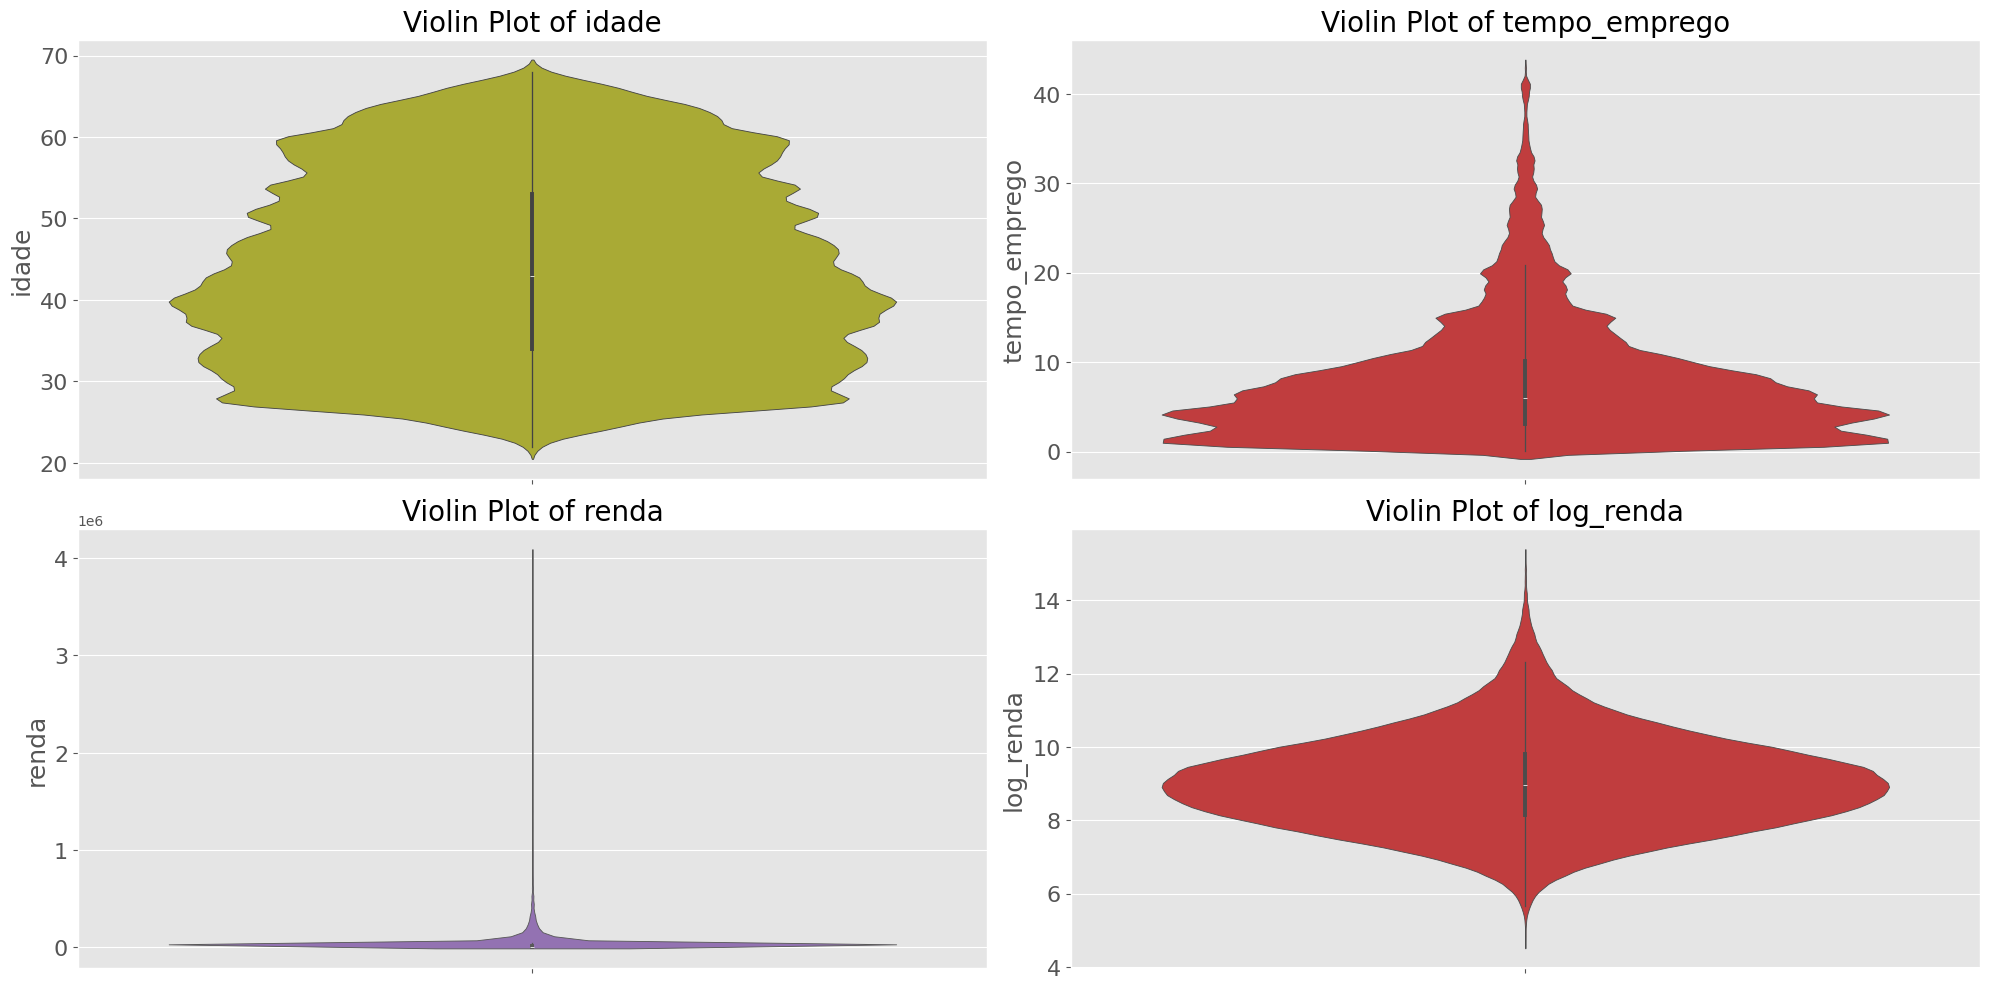

In [130]:
univ_plot(df, categorical=False)

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

<Figure size 1000x600 with 0 Axes>

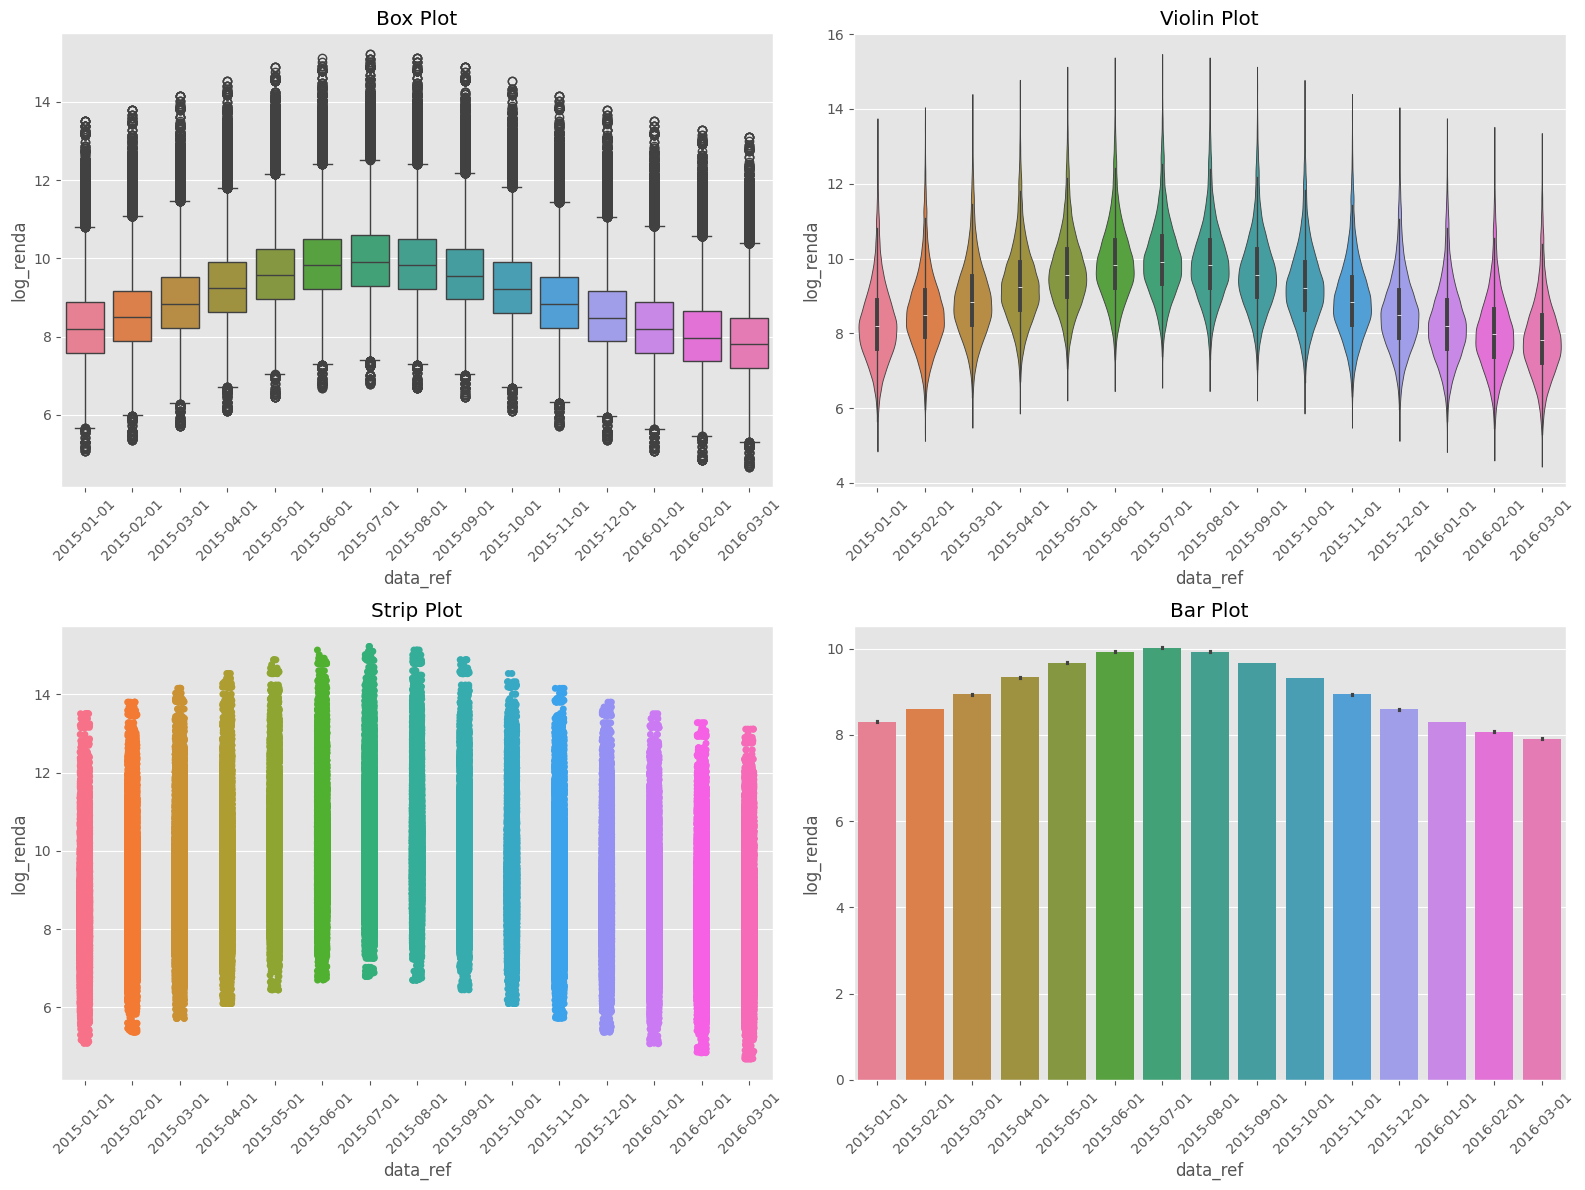

In [132]:
biv_plot(df, x='data_ref', y='log_renda', threshold=15)

### Claramente existe um viés na coleta de dados, o que fez com que informações de renda coletadas por volta do ano de 2015, tendessem a um valor mais alto.

<Figure size 1000x600 with 0 Axes>

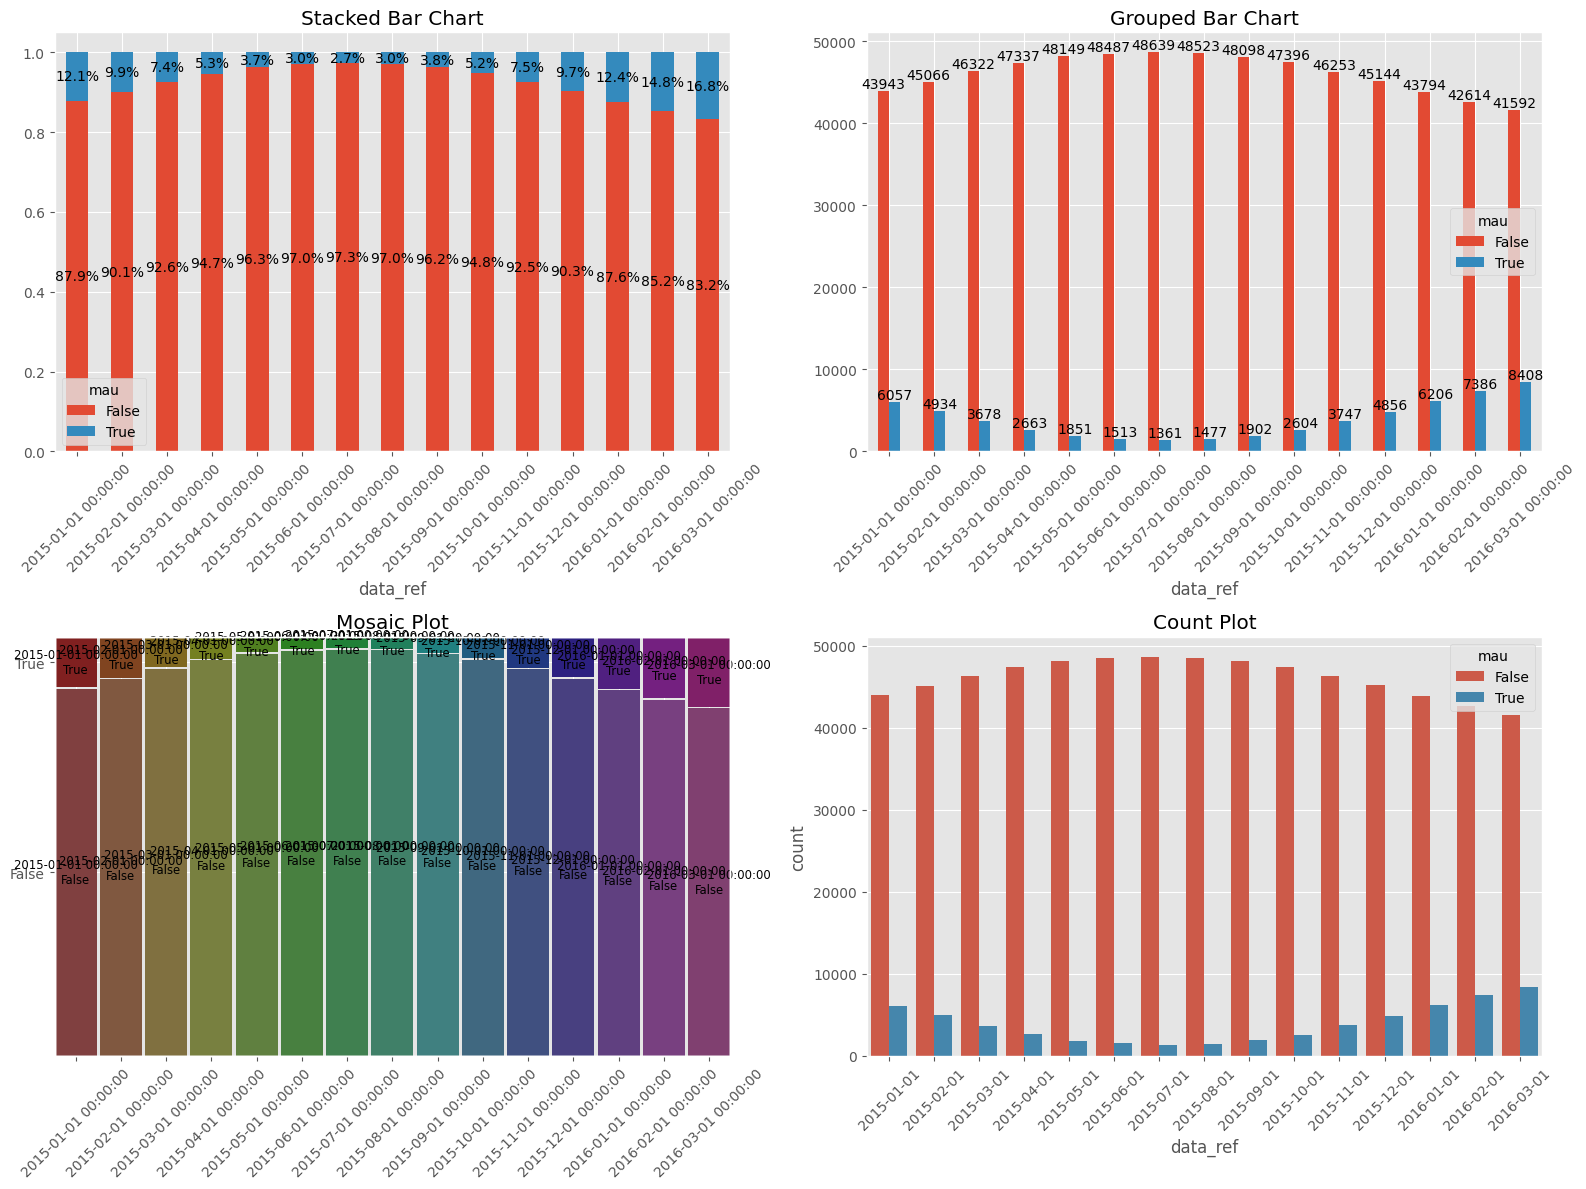

In [134]:
biv_plot(df, x='data_ref', y='mau', threshold=15)

<Figure size 1000x600 with 0 Axes>

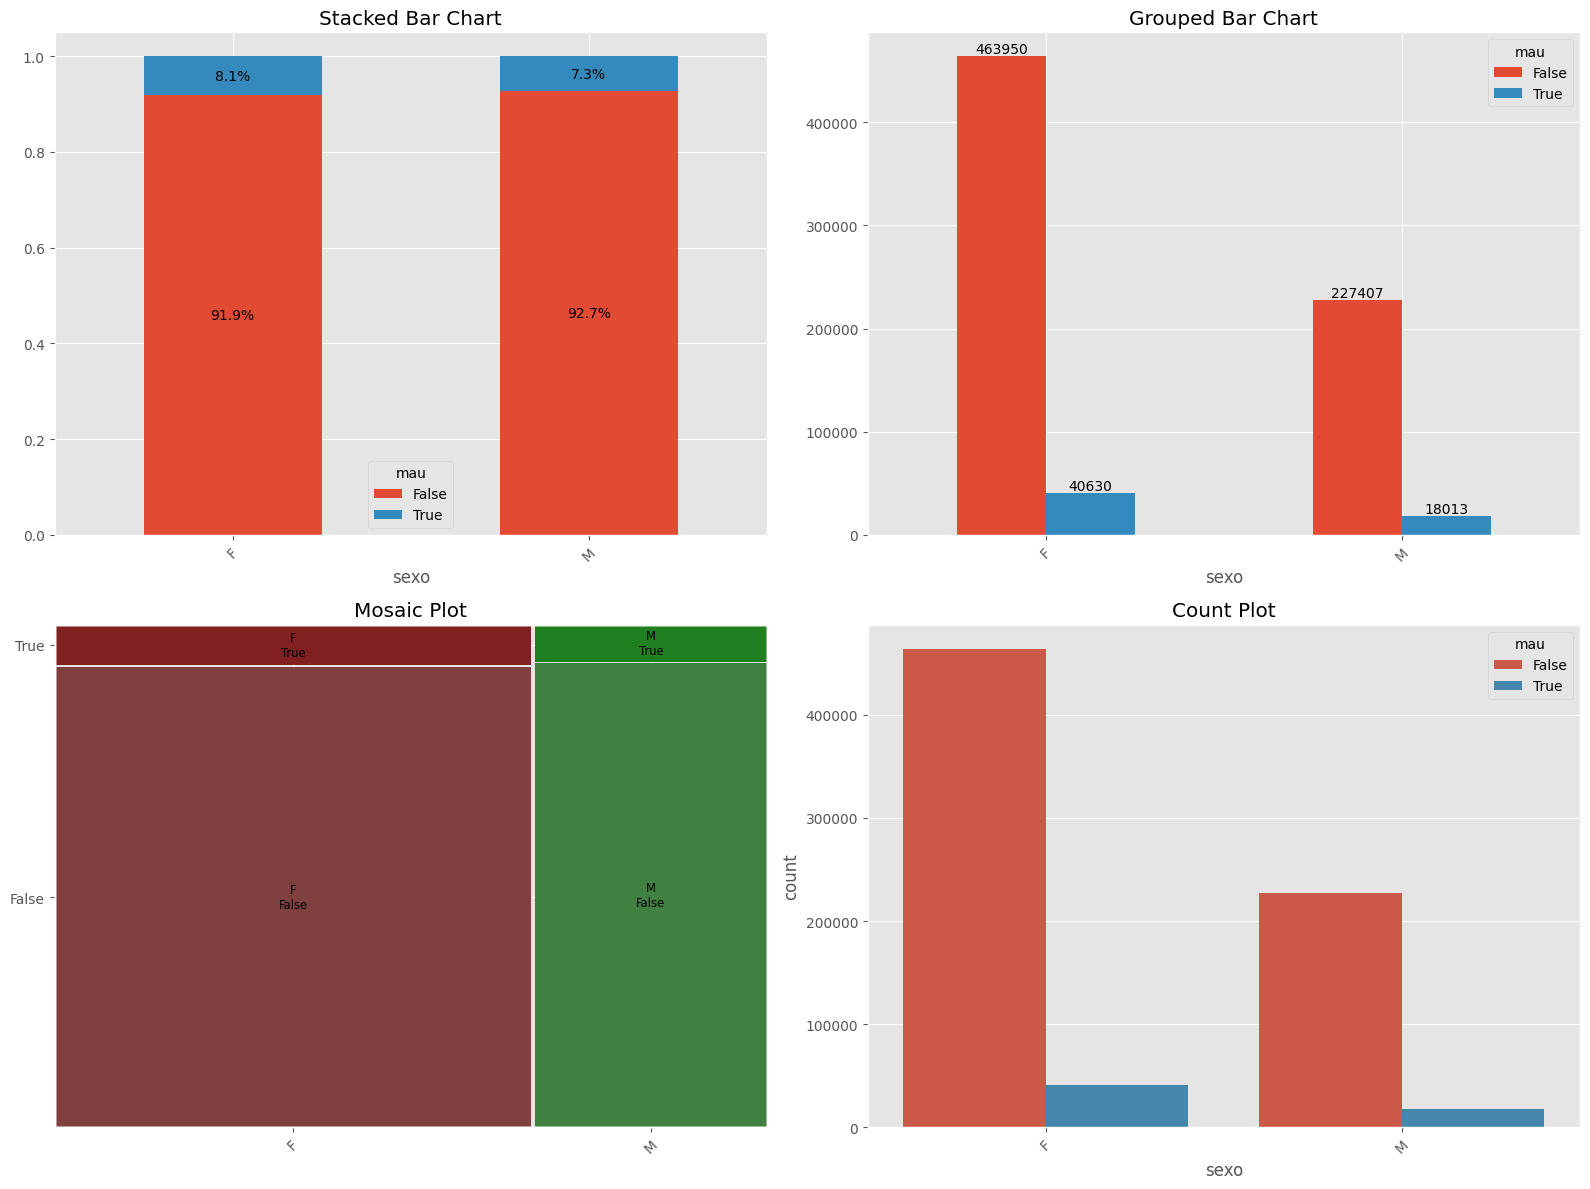

In [135]:
biv_plot(df, x='sexo', y='mau', threshold=15)

<Figure size 1000x600 with 0 Axes>

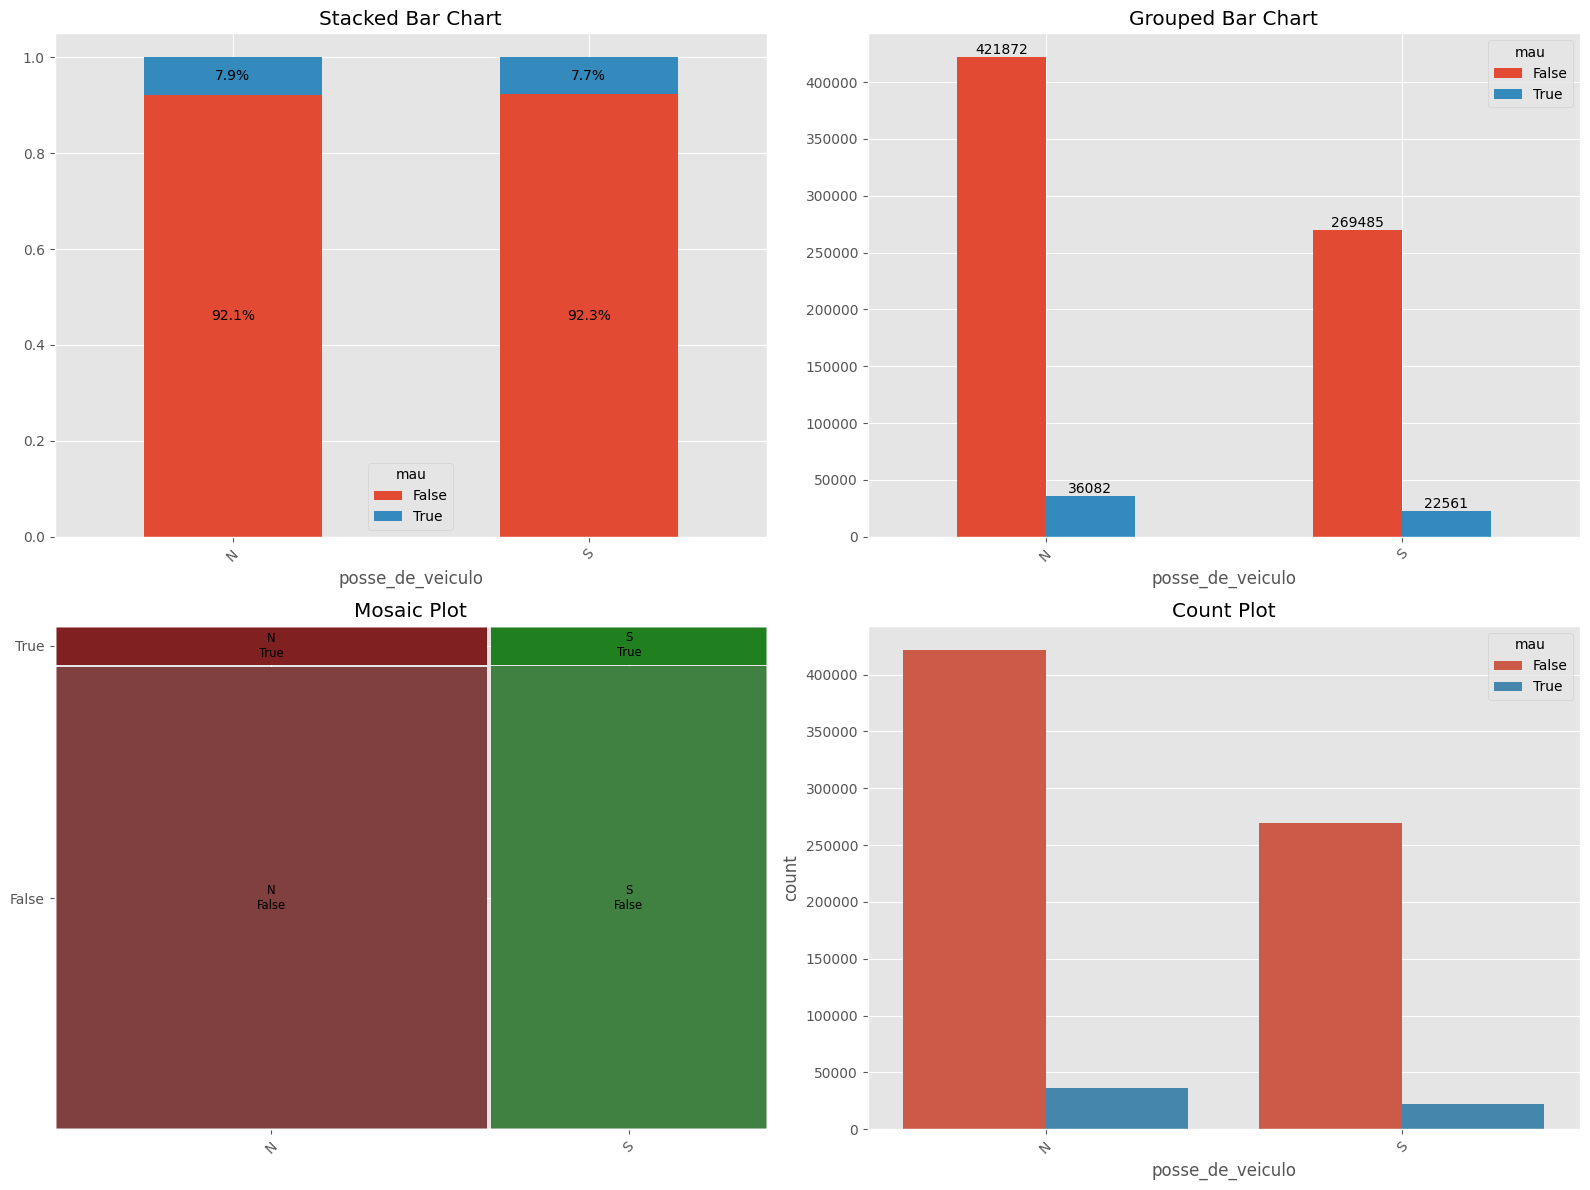

In [136]:
biv_plot(df, x='posse_de_veiculo', y='mau', threshold=15)

### Posse de veículo parece não ter nenhum Impacto para prever se um cliente é mau ou não

<Figure size 1000x600 with 0 Axes>

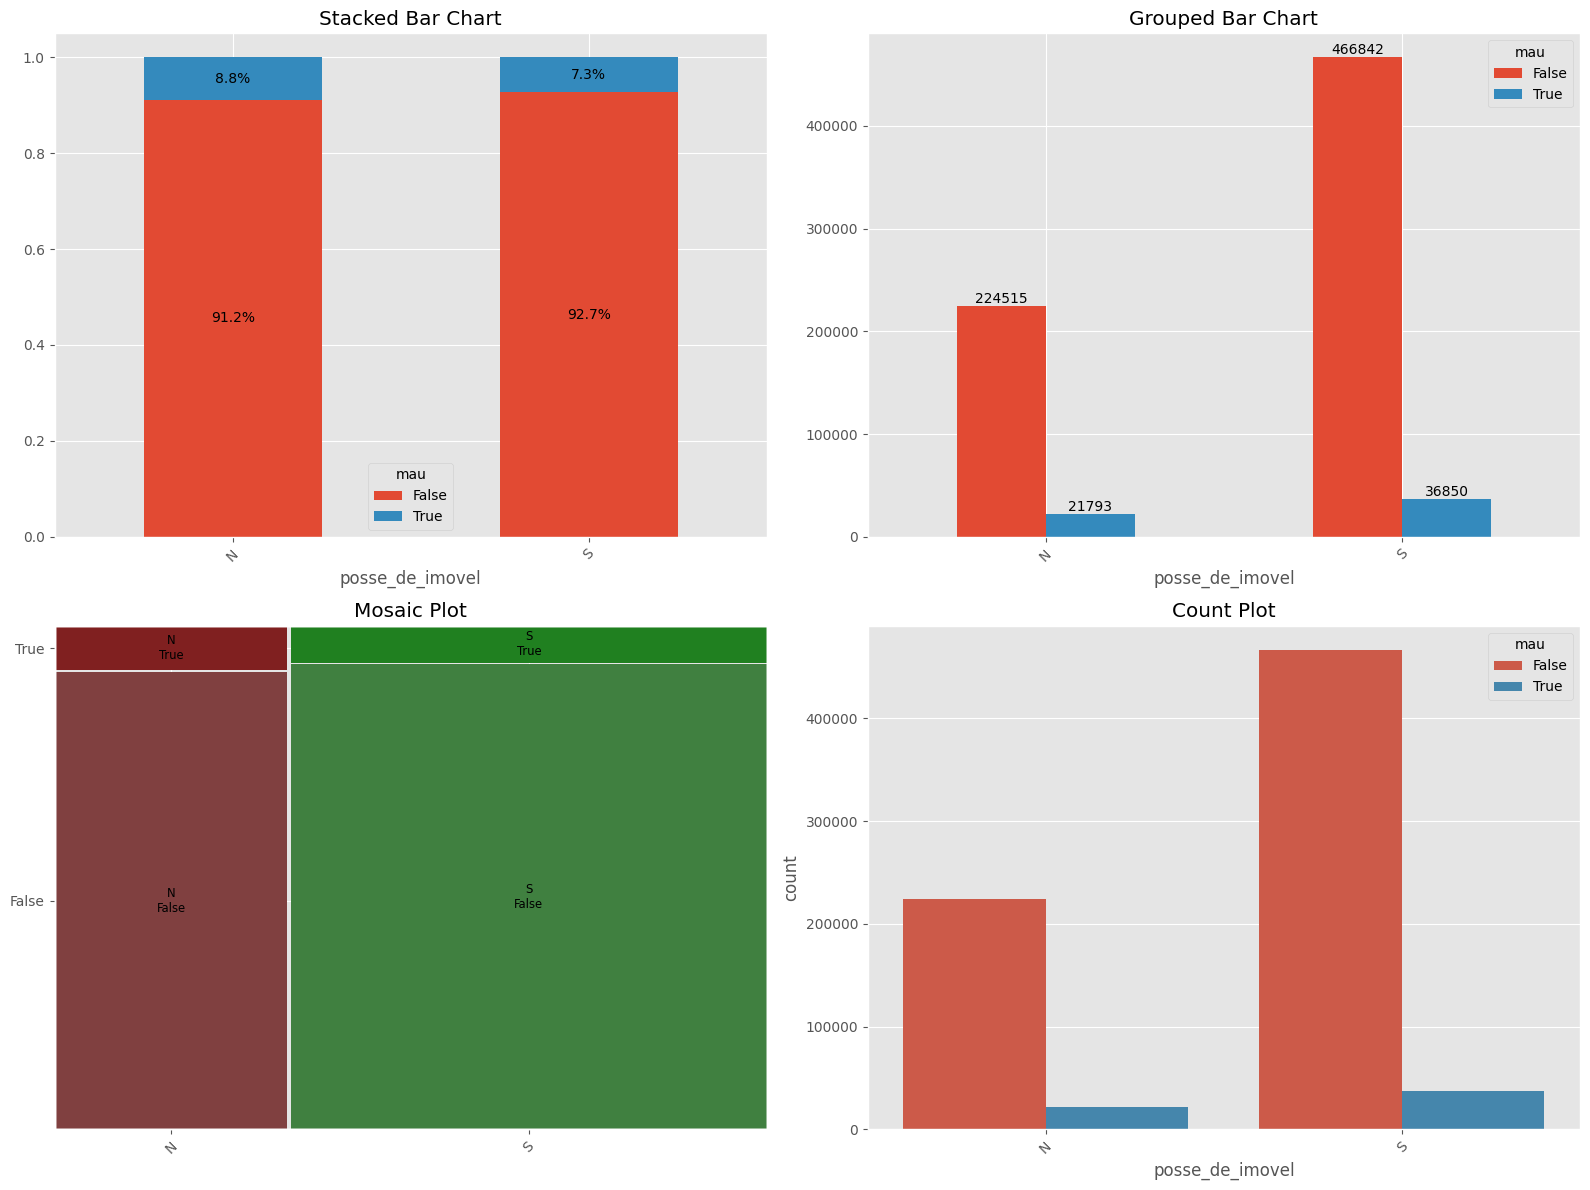

In [138]:
biv_plot(df, x='posse_de_imovel', y='mau', threshold=15)

### Posse de imóvel não parece ser uma variável determinante para discriminar se um cliente é mau ou não

<Figure size 1000x600 with 0 Axes>

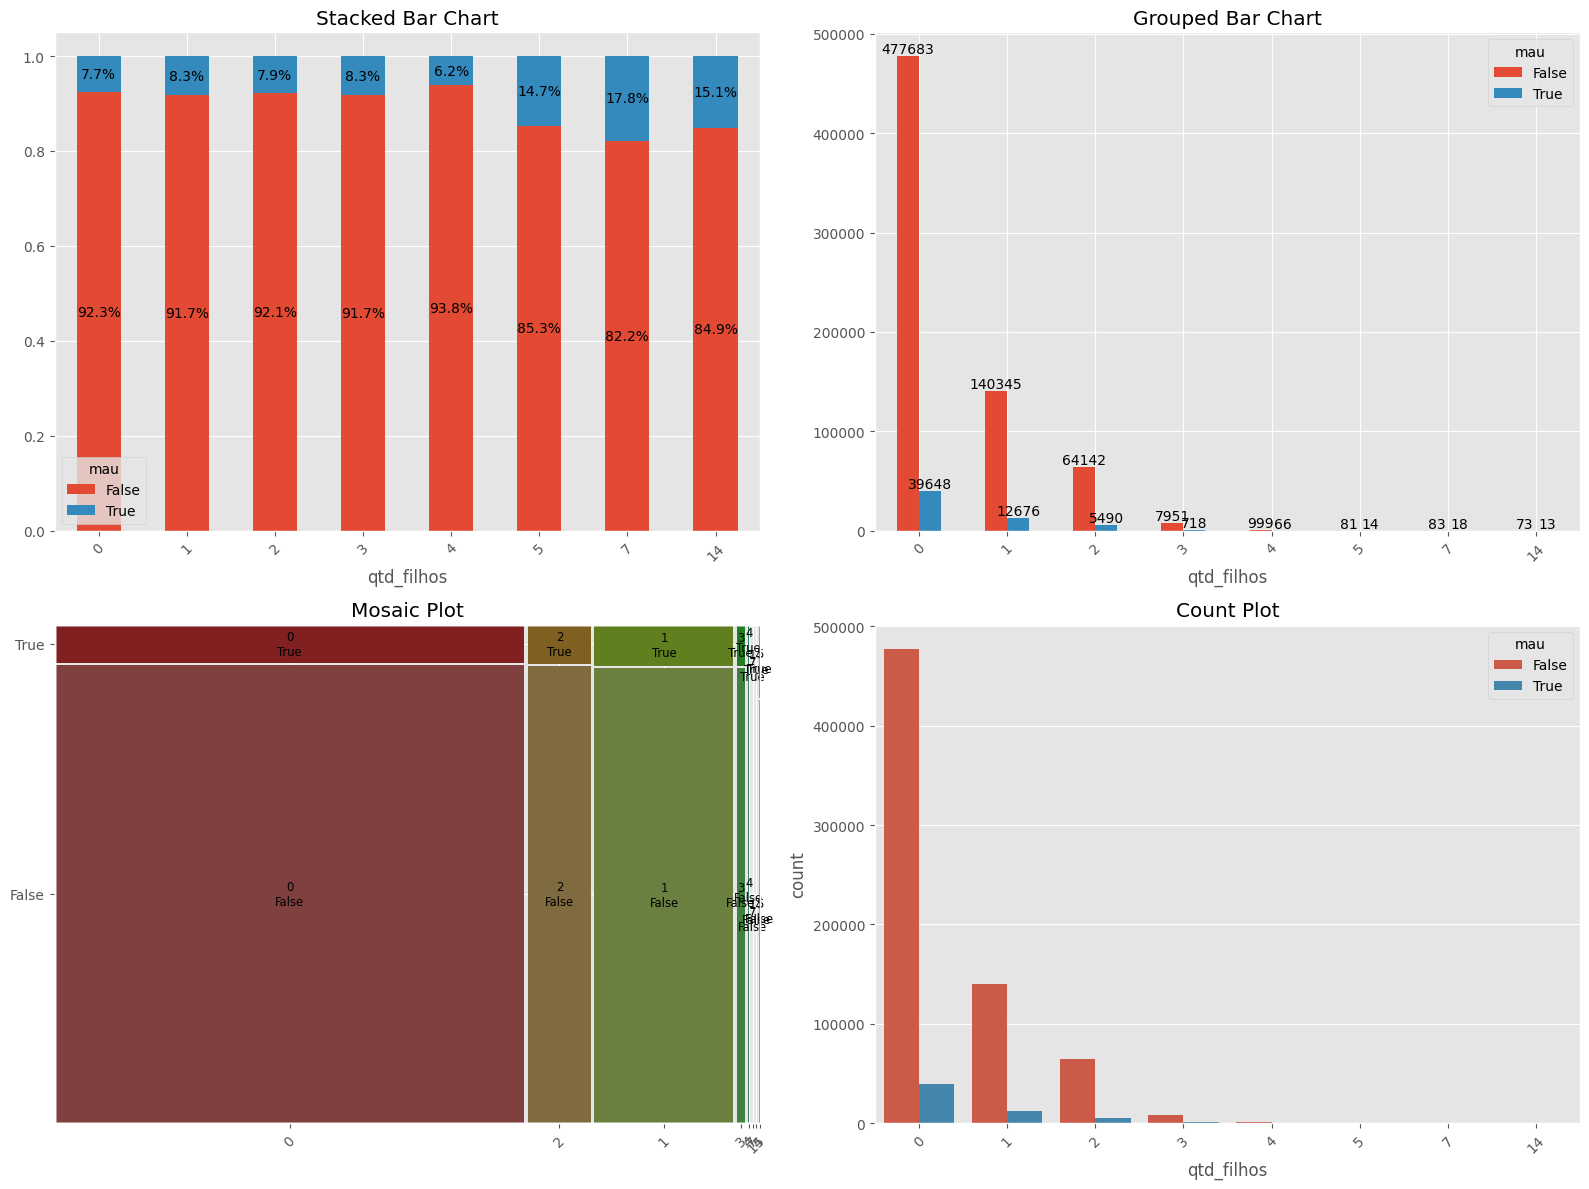

In [140]:
biv_plot(df, x='qtd_filhos', y='mau', threshold=15)

### Os clientes maus parecem aumentar conforme a quantidade de filhos aumenta, porém não podemos afirmar isso com completa certeza por conta do baixo valor amostral nos valores mais altos de quantidade de filhos

<Figure size 1000x600 with 0 Axes>

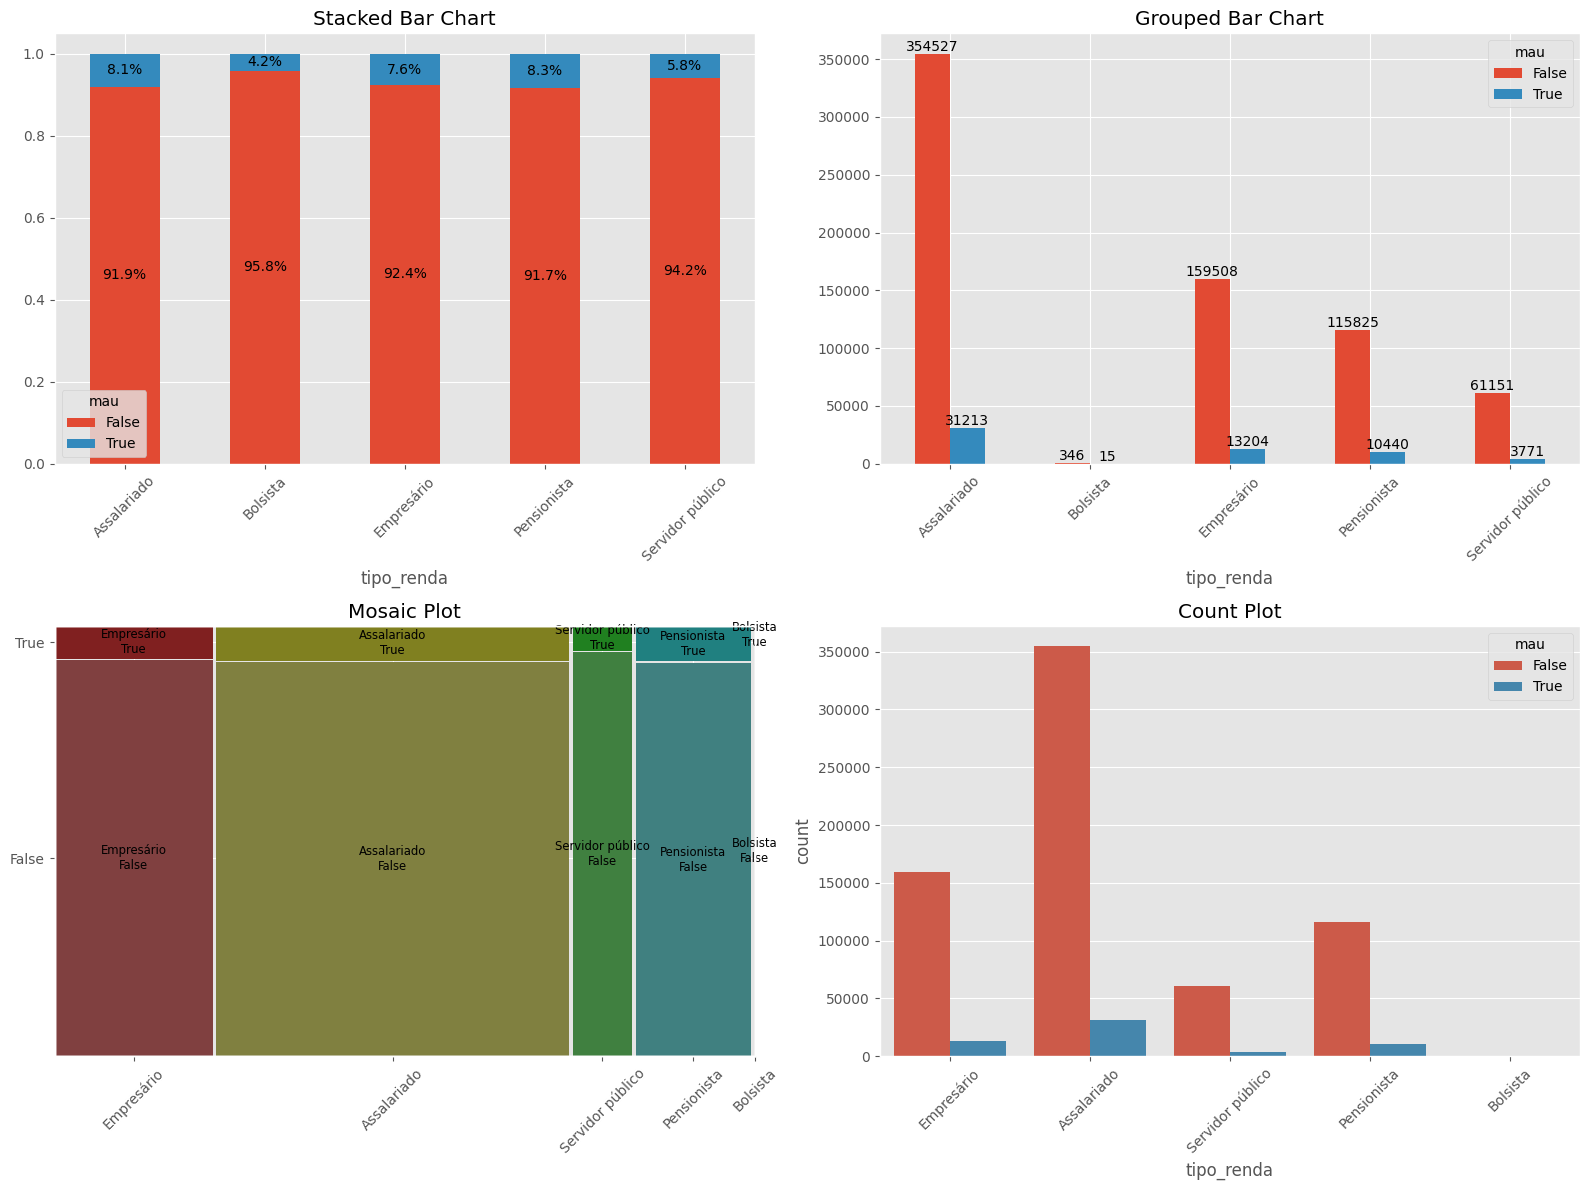

In [142]:
biv_plot(df, x='tipo_renda', y='mau', threshold=15)

### o tipo de renda também não parece discriminar se um cliente é mau ou não

<Figure size 1000x600 with 0 Axes>

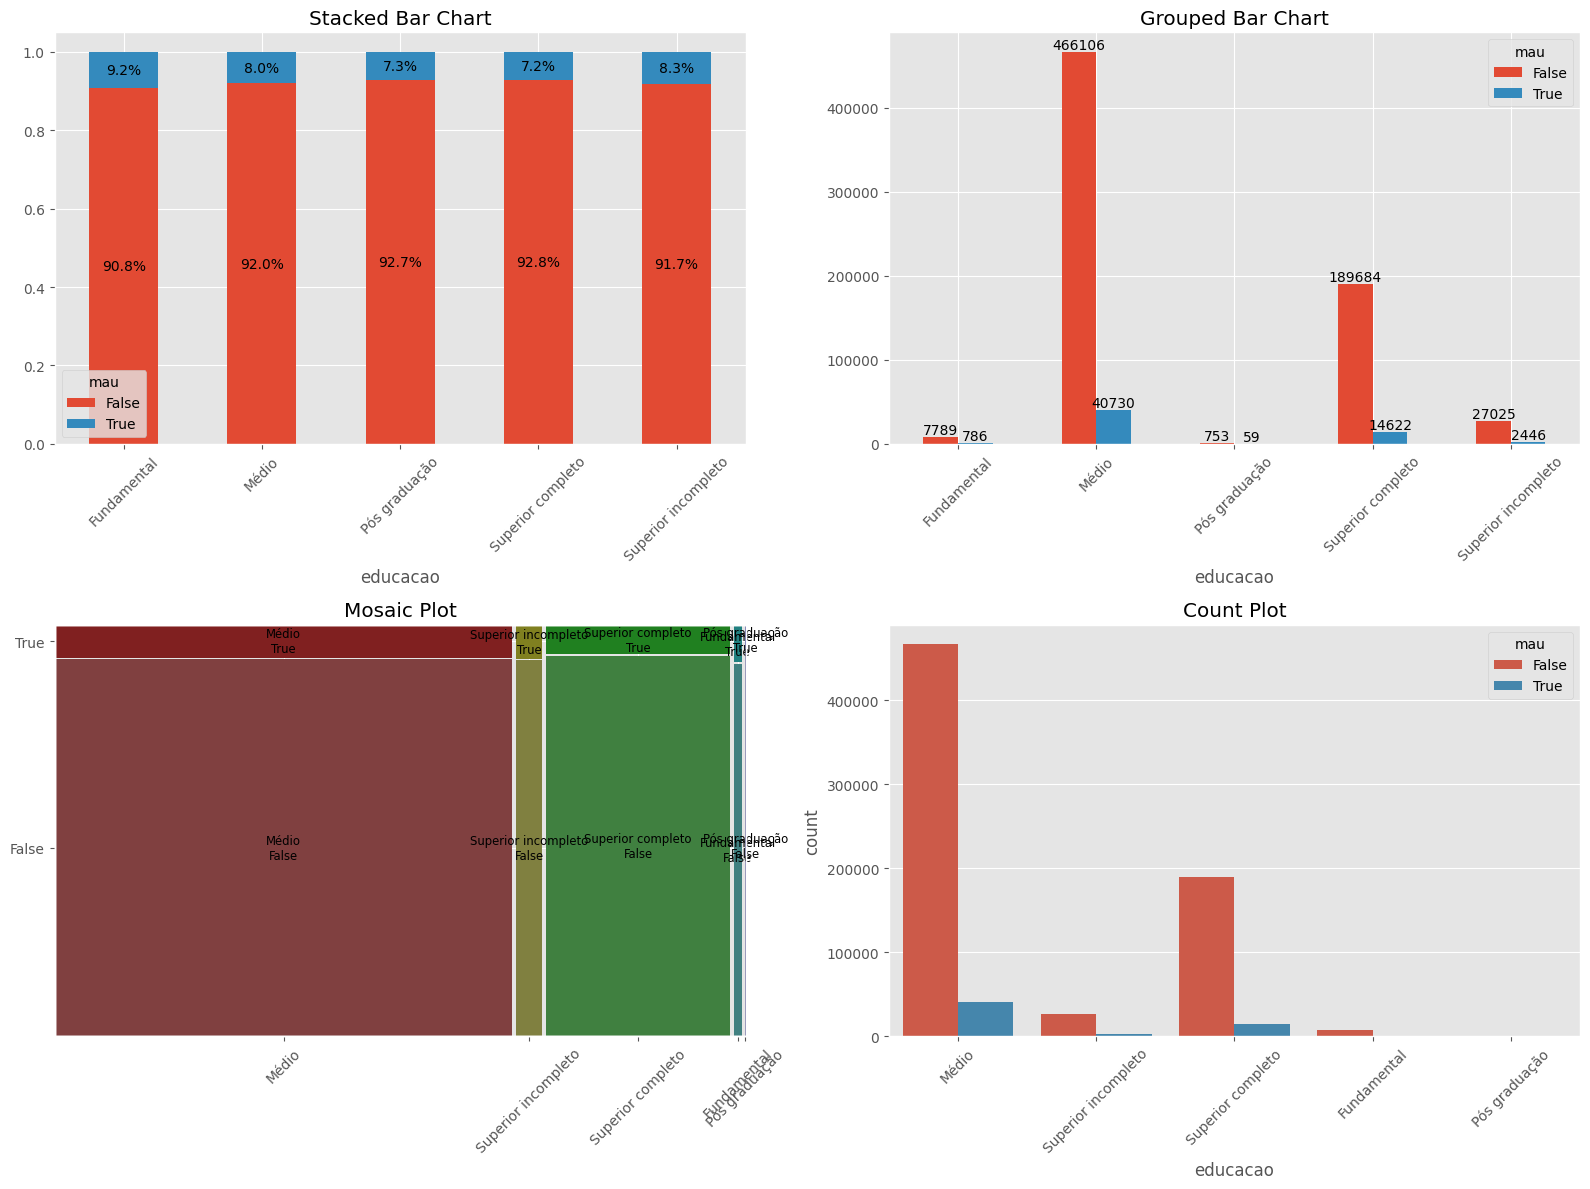

In [144]:
biv_plot(df, x='educacao', y='mau', threshold=15)

<Figure size 1000x600 with 0 Axes>

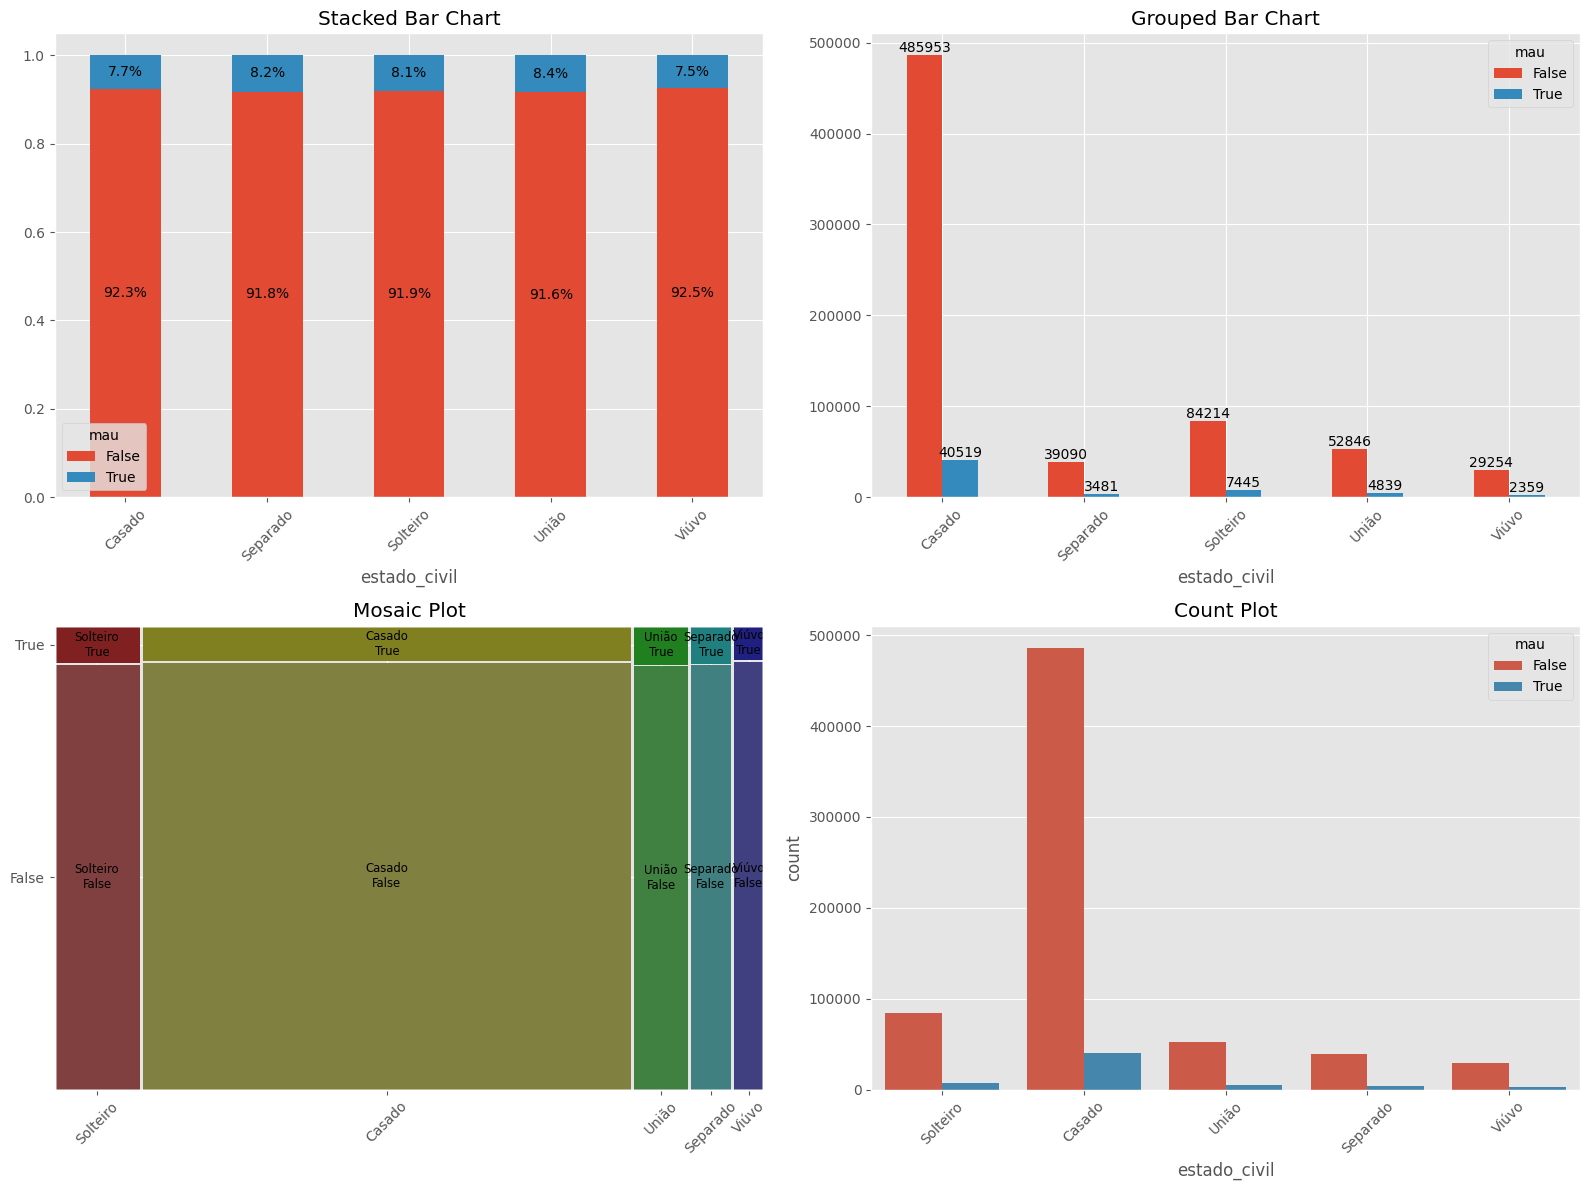

In [145]:
biv_plot(df, x='estado_civil', y='mau', threshold=15)

<Figure size 1000x600 with 0 Axes>

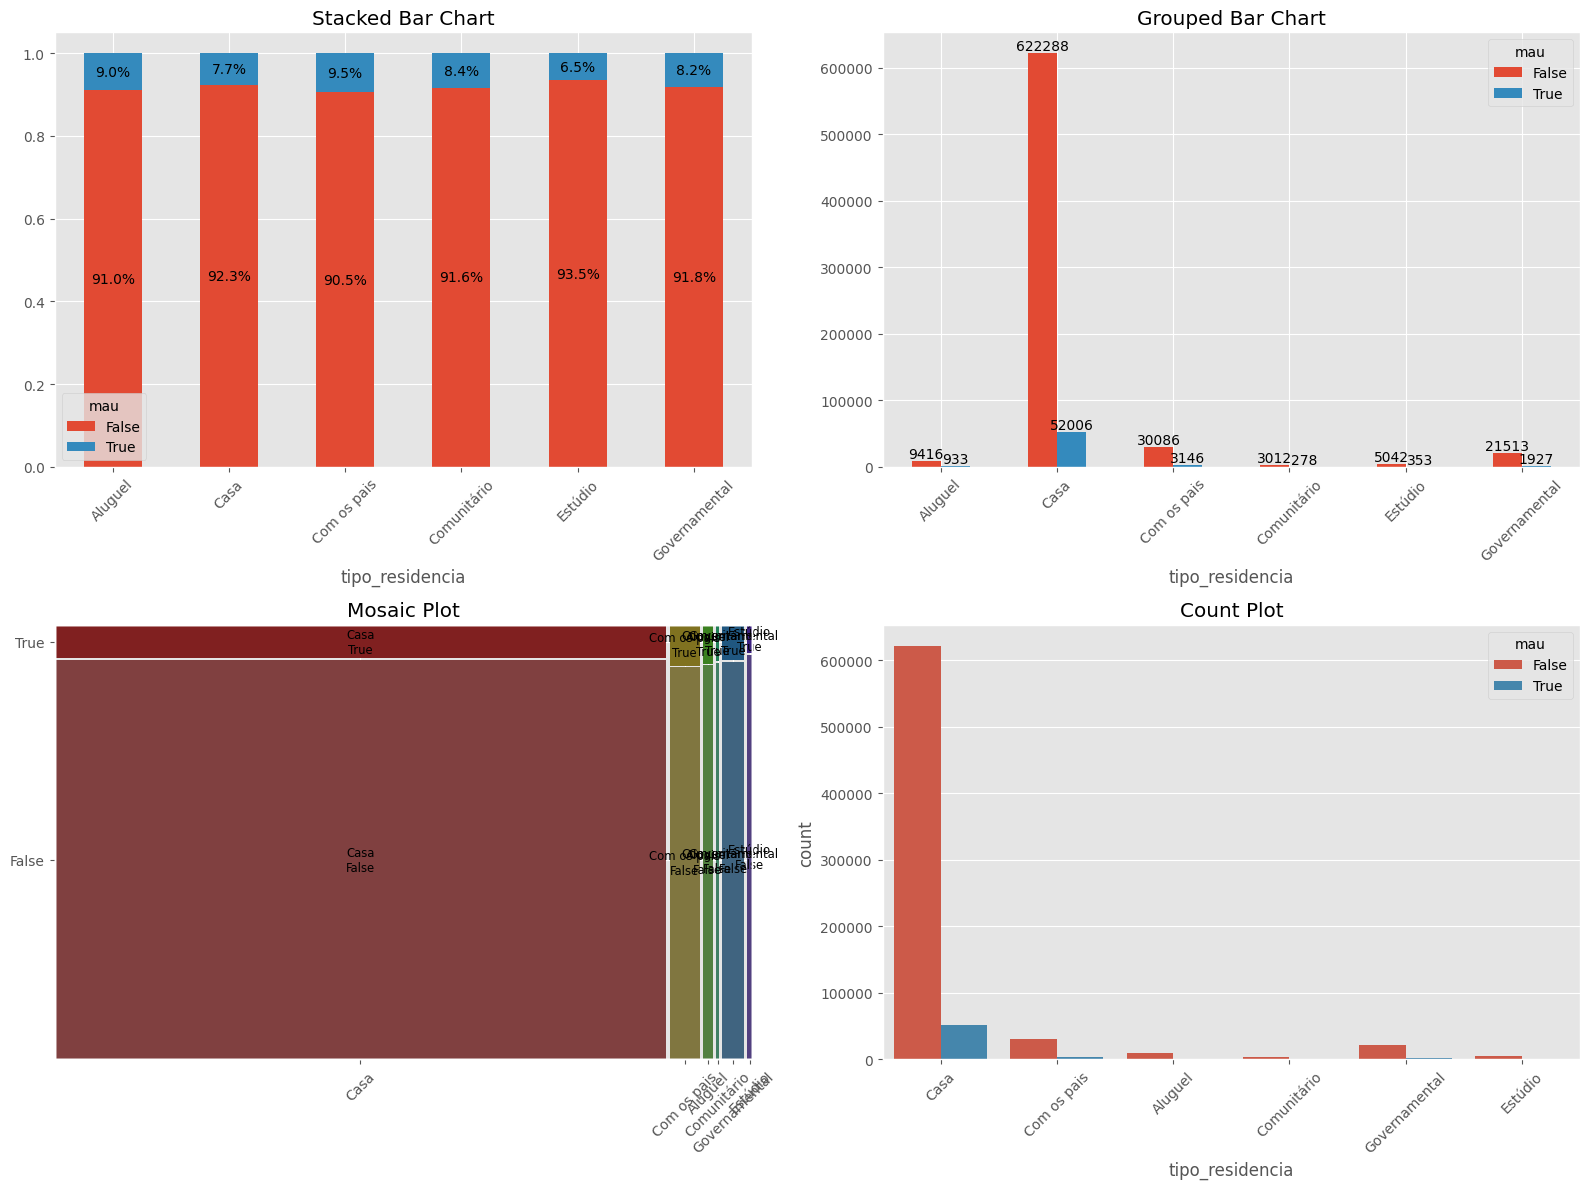

In [146]:
biv_plot(df, x='tipo_residencia', y='mau', threshold=15)

<Figure size 1000x600 with 0 Axes>

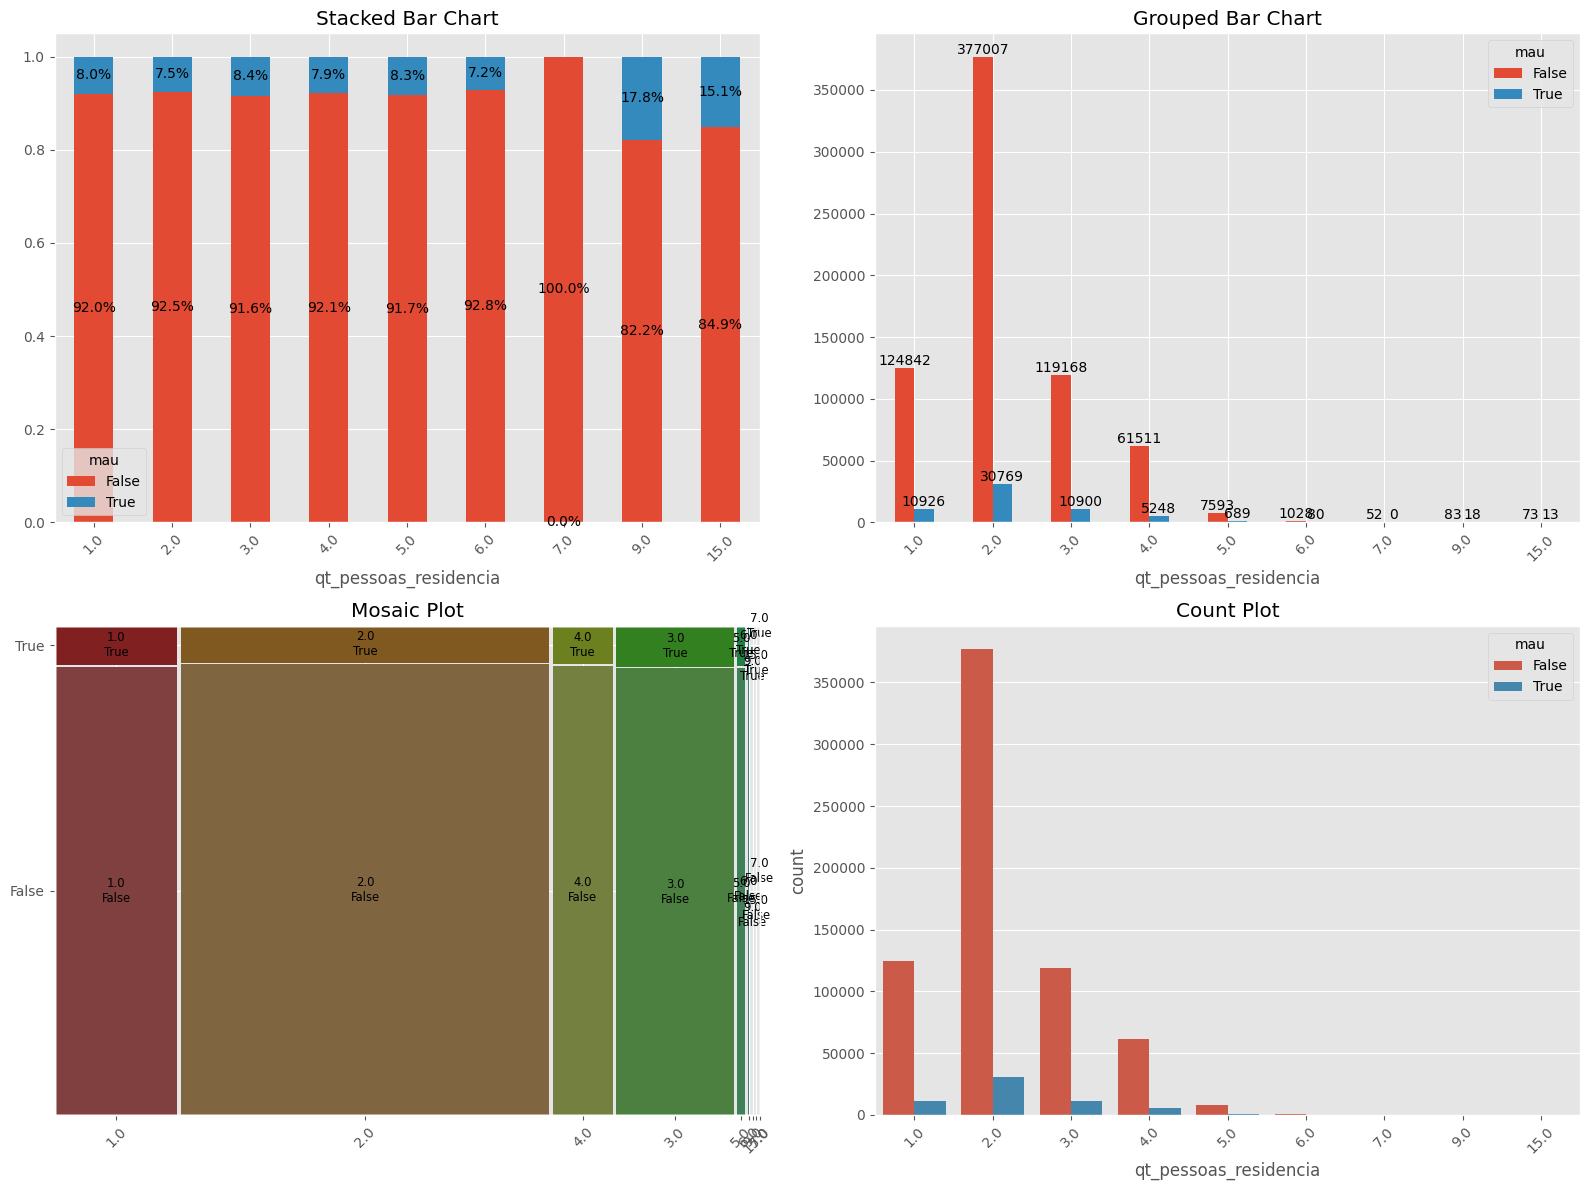

In [147]:
biv_plot(df, x='qt_pessoas_residencia', y='mau', threshold=15)

<Figure size 1000x600 with 0 Axes>

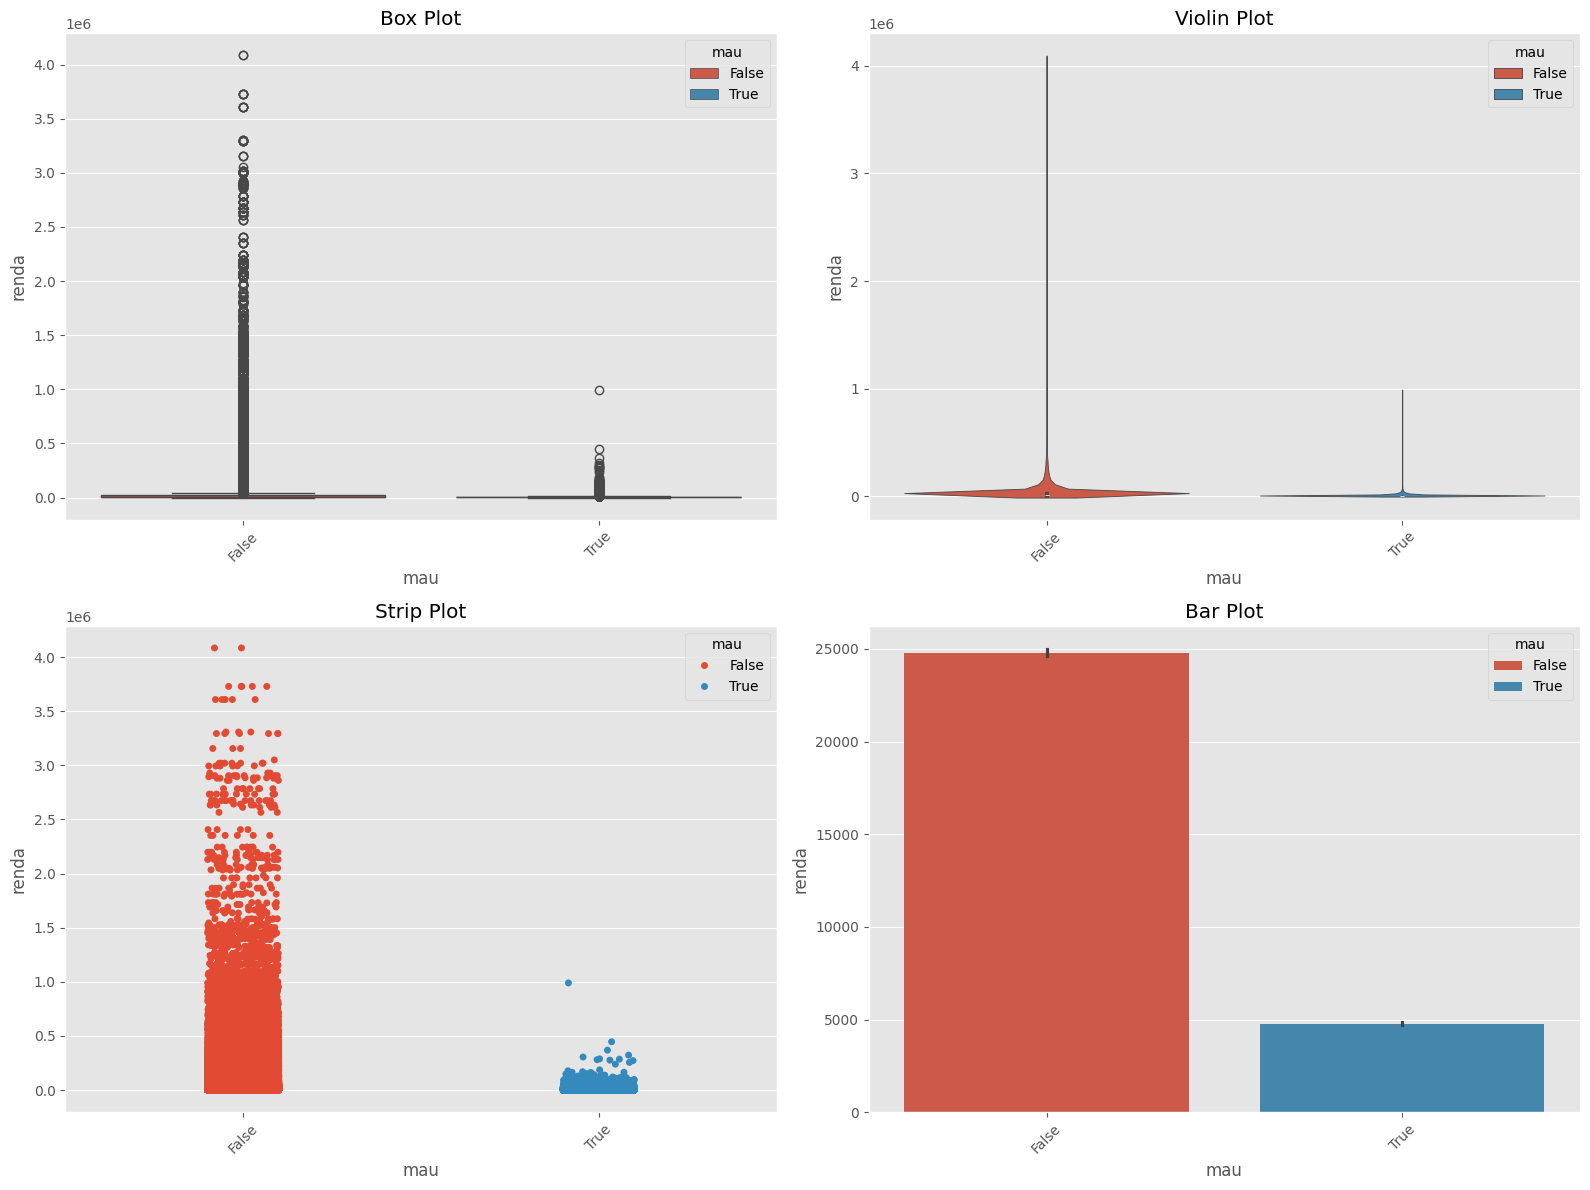

In [148]:
biv_plot(df, x='renda', y='mau', threshold=15)

<Figure size 1000x600 with 0 Axes>

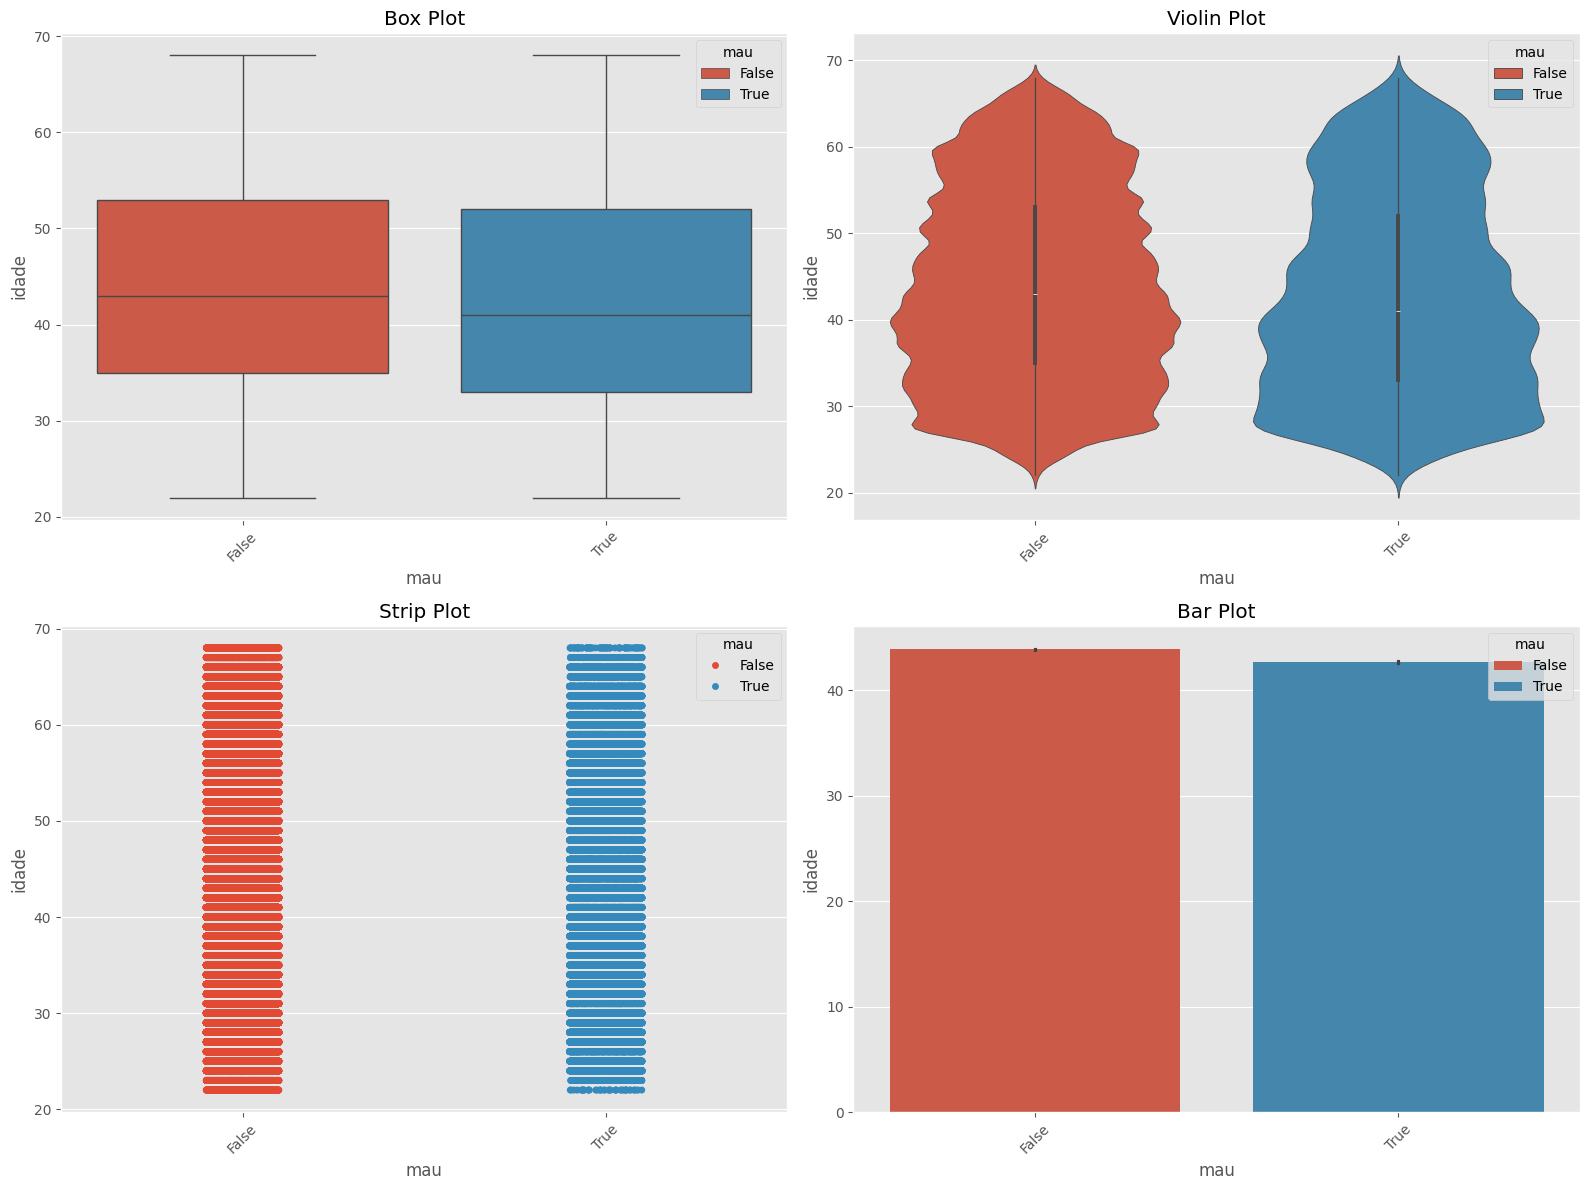

In [149]:
biv_plot(df, x='idade', y='mau', threshold=15)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [151]:
df['mau'] = df.mau.astype('int64')
df['tempo_emprego'] = df['tempo_emprego'].fillna(df['tempo_emprego'].mean())

In [152]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [153]:
iv_sexo = IV(df.sexo, df.mau)
print(f'IV da variável SEXO: {iv_sexo:.1%}')

IV da variável SEXO: 0.2%


In [154]:
metadados = pd.DataFrame(df.dtypes, columns=['dtype'])
metadados['nmissing'] = df.isna().sum()
metadados['valores_unicos'] = df.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0.0,15.0,covariavel
sexo,object,0.0,2.0,covariavel
posse_de_veiculo,object,0.0,2.0,covariavel
posse_de_imovel,object,0.0,2.0,covariavel
qtd_filhos,int64,0.0,8.0,covariavel
tipo_renda,object,0.0,5.0,covariavel
educacao,object,0.0,5.0,covariavel
estado_civil,object,0.0,5.0,covariavel
tipo_residencia,object,0.0,6.0,covariavel
idade,int64,0.0,47.0,covariavel


In [155]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df[var],5,duplicates='drop'), df.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df[var], df.mau)

    
metadados

,dtype,nmissing,valores_unicos,papel,IV
data_ref,datetime64[ns],0.0,15.0,covariavel,0.345982
sexo,object,0.0,2.0,covariavel,0.002185
posse_de_veiculo,object,0.0,2.0,covariavel,0.000108
posse_de_imovel,object,0.0,2.0,covariavel,0.009693
qtd_filhos,int64,0.0,8.0,covariavel,0.000030
tipo_renda,object,0.0,5.0,covariavel,0.009360
educacao,object,0.0,5.0,covariavel,0.003547
estado_civil,object,0.0,5.0,covariavel,0.001126
tipo_residencia,object,0.0,6.0,covariavel,0.003045
idade,int64,0.0,47.0,covariavel,0.017968


In [156]:
metadados['IV'].sort_values(ascending=False)

renda                    1.068628
log_renda                1.068628
data_ref                 0.345982
tempo_emprego            0.278819
idade                    0.017968
posse_de_imovel          0.009693
tipo_renda               0.009360
educacao                 0.003547
tipo_residencia          0.003045
sexo                     0.002185
qt_pessoas_residencia    0.001346
estado_civil             0.001126
posse_de_veiculo         0.000108
qtd_filhos               0.000030
mau                           NaN
bom                           NaN
Name: IV, dtype: float64

In [157]:
from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t

In [158]:
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,485953,40519,0.076963,Casado,526472,0.000367,0.077683,0.076243,-2.484341,-2.474249,-2.494519,-0.017153,-0.007061,-0.027331
Separado,39090,3481,0.081769,Separado,42571,0.001328,0.084372,0.079166,-2.418547,-2.384371,-2.453729,0.048641,0.082817,0.013459
Solteiro,84214,7445,0.081225,Solteiro,91659,0.000902,0.082994,0.079456,-2.425819,-2.402352,-2.449755,0.041370,0.064836,0.017433
União,52846,4839,0.083887,União,57685,0.001154,0.086149,0.081624,-2.390674,-2.361590,-2.420479,0.076514,0.105598,0.046709
Viúvo,29254,2359,0.074621,Viúvo,31613,0.001478,0.077518,0.071724,-2.517779,-2.476557,-2.560498,-0.050590,-0.009369,-0.093310


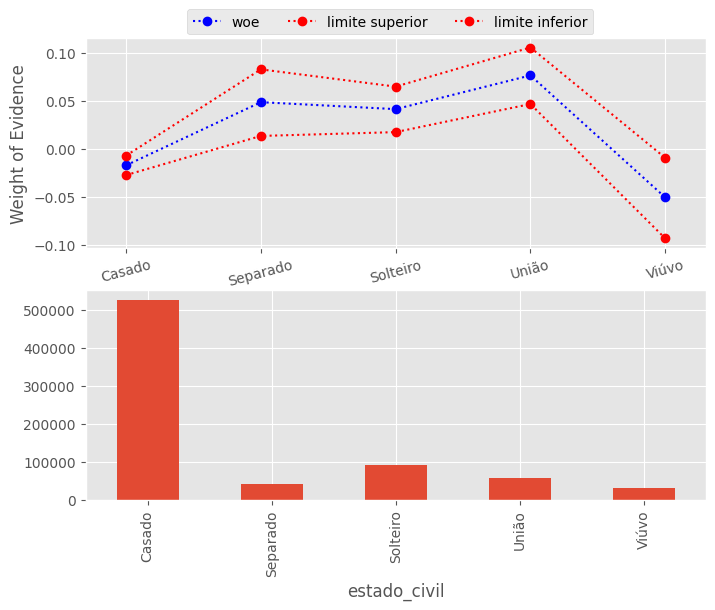

In [159]:
biv_discreta('estado_civil', df)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,354527,31213,0.080917,Assalariado,385740,0.000439,0.081778,0.080057,-2.429950,-2.418434,-2.441578,0.037238,0.048754,0.025610
Bolsista,346,15,0.041551,Bolsista,361,0.010503,0.062207,0.020896,-3.138389,-2.713068,-3.847087,-0.671200,-0.245880,-1.379899
Empresário,159508,13204,0.076451,Empresário,172712,0.000639,0.077704,0.075198,-2.491574,-2.473957,-2.509458,-0.024386,-0.006769,-0.042270
Pensionista,115825,10440,0.082683,Pensionista,126265,0.000775,0.084202,0.081164,-2.406436,-2.386573,-2.426634,0.060752,0.080615,0.040555
Servidor público,61151,3771,0.058085,Servidor público,64922,0.000918,0.059884,0.056286,-2.786006,-2.753587,-2.819381,-0.318818,-0.286399,-0.352193


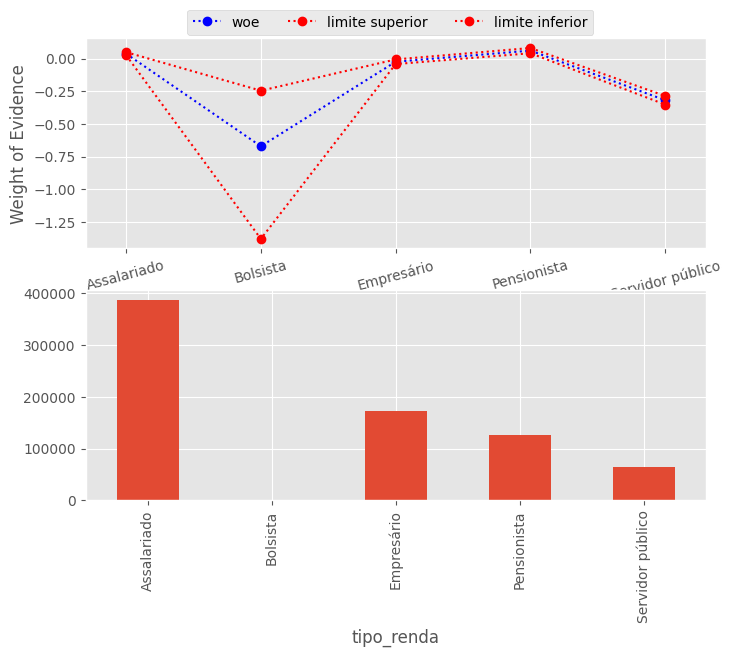

In [160]:
biv_discreta('tipo_renda', df)

In [161]:
df2 = df.copy()

C:\Users\Hanga\AppData\Local\Temp\ipykernel_30524\1686565225.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2.tipo_renda.replace({'Bolsista': 'Serv.Publico/Bolsista', 'Servidor público': 'Serv.Publico/Bolsista'}, inplace=True)


,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,354527,31213,0.080917,Assalariado,385740,0.000439,0.081778,0.080057,-2.429950,-2.418434,-2.441578,0.037238,0.048754,0.025610
Empresário,159508,13204,0.076451,Empresário,172712,0.000639,0.077704,0.075198,-2.491574,-2.473957,-2.509458,-0.024386,-0.006769,-0.042270
Pensionista,115825,10440,0.082683,Pensionista,126265,0.000775,0.084202,0.081164,-2.406436,-2.386573,-2.426634,0.060752,0.080615,0.040555
Serv.Publico/Bolsista,61497,3786,0.057994,Serv.Publico/Bolsista,65283,0.000915,0.059787,0.056201,-2.787678,-2.755325,-2.820985,-0.320490,-0.288137,-0.353796


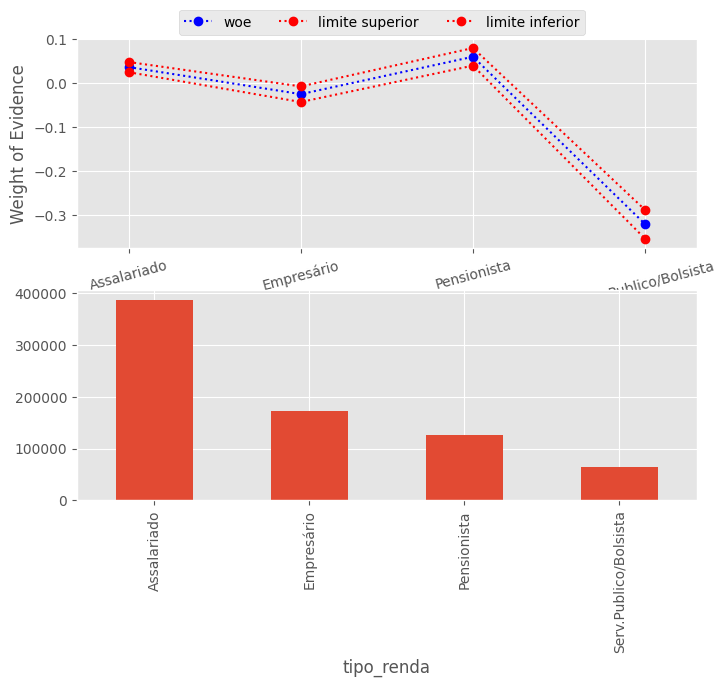

In [162]:

df2.tipo_renda.replace({'Bolsista': 'Serv.Publico/Bolsista', 'Servidor público': 'Serv.Publico/Bolsista'}, inplace=True)
biv_discreta('tipo_renda', df2)

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,9416,933,0.090154,Aluguel,10349,0.002815,0.095672,0.084635,-2.311760,-2.246264,-2.380974,0.155428,0.220924,0.086214
Casa,622288,52006,0.077127,Casa,674294,0.000325,0.077763,0.076490,-2.482044,-2.473131,-2.491024,-0.014856,-0.005943,-0.023836
Com os pais,30086,3146,0.094668,Com os pais,33232,0.001606,0.097815,0.091520,-2.257928,-2.221736,-2.295214,0.209260,0.245452,0.171974
Comunitário,3012,278,0.084498,Comunitário,3290,0.004849,0.094006,0.074991,-2.382738,-2.265675,-2.512435,0.084450,0.201513,-0.045247
Estúdio,5042,353,0.065431,Estúdio,5395,0.003367,0.072031,0.058831,-2.659090,-2.555902,-2.772455,-0.191902,-0.088714,-0.305267
Governamental,21513,1927,0.082210,Governamental,23440,0.001794,0.085727,0.078693,-2.412693,-2.366968,-2.460235,0.054495,0.100221,0.006953


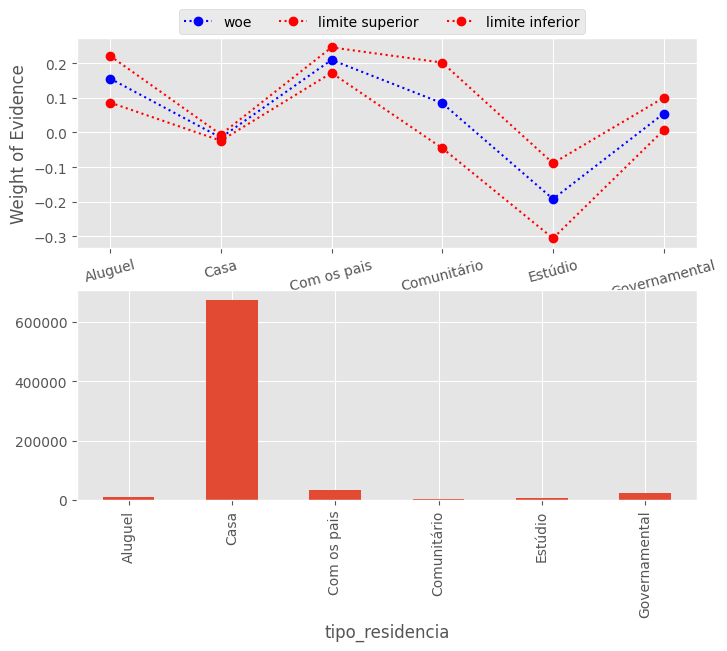

In [163]:
biv_discreta('tipo_residencia', df2)

In [164]:
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

C:\Users\Hanga\AppData\Local\Temp\ipykernel_30524\707398857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


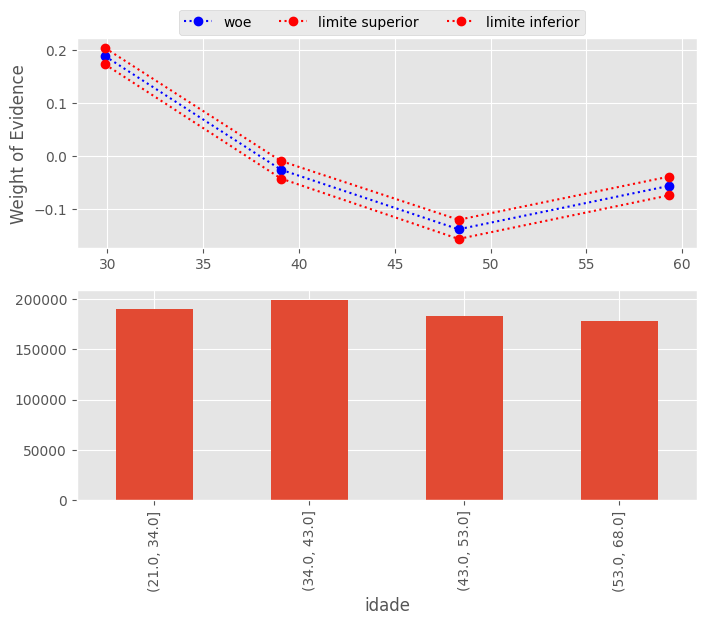

In [165]:
biv_continua('idade', 4, df)

C:\Users\Hanga\AppData\Local\Temp\ipykernel_30524\707398857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


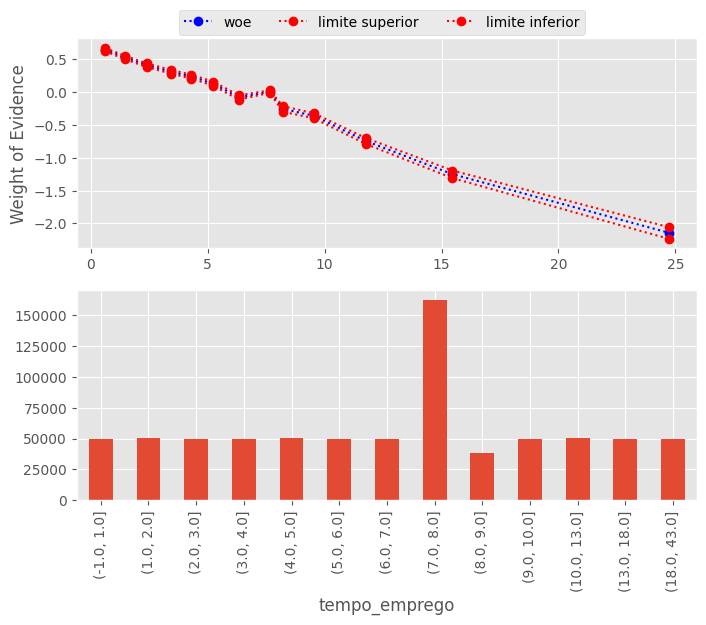

In [166]:
df2.loc[df2['tempo_emprego']<0,'tempo_emprego'] = -1
biv_continua('tempo_emprego', 15, df2)

In [167]:
oot_test = df2[df2['data_ref'] >= '2016-01-01']
train = df2[df2['data_ref'] < '2016-01-01']

y_oot_test = oot_test['mau']
X_oot_test = oot_test.drop(columns=['mau'])

X_train = train.drop(columns=['mau'])
y_train = train['mau']

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [171]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [173]:
from sklearn.feature_selection import RFE

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [176]:
pca_pipe = PCA(n_components=5)
scaler_pipe = StandardScaler()
logistic_pipe = LogisticRegression(max_iter=200)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [214]:
from sklearn.preprocessing import FunctionTransformer

In [216]:
def convert_categorical_to_dummies(df):
    df_with_dummies = pd.get_dummies(df, drop_first=True)
    
    return df_with_dummies

In [218]:
oot_test = df2[df2['data_ref'] >= '2016-01-01'].copy()
train = df2[df2['data_ref'] < '2016-01-01'].copy()

oot_test.drop(columns=['data_ref'], inplace=True)
train.drop(columns=['data_ref'], inplace=True)

y_oot_test = oot_test['mau']
X_oot_test = oot_test.drop(columns=['mau'])

X_train = train.drop(columns=['mau'])
y_train = train['mau']

In [221]:
pipeline = Pipeline(steps=[
    ("dummies", FunctionTransformer(convert_categorical_to_dummies, validate=False)),
    ("scaler", StandardScaler()),                        
    ("pca", PCA(n_components=5)),                        
    ("logistic", LogisticRegression())                  
])

In [223]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('dummies',
                 FunctionTransformer(func=<function convert_categorical_to_dummies at 0x000001BAA2F32CA0>)),
                ('scaler', StandardScaler()), ('pca', PCA(n_components=5)),
                ('logistic', LogisticRegression())])

In [225]:
from sklearn.metrics import accuracy_score

In [227]:
y_oot_pred = pipeline.predict(X_oot_test)
accuracy = accuracy_score(y_oot_test, y_oot_pred)
print(f"Accuracy on the out-of-time test set: {accuracy:.4f}")

Accuracy on the out-of-time test set: 0.9181


# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [231]:
import pandas as pd

df3 = pd.read_feather('./data/credit_scoring.ftr')
df3.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [239]:
from pycaret.classification import *
models()

ModuleNotFoundError: No module named 'pycaret'

In [241]:
xxx = create_model('xxx')

NameError: name 'create_model' is not defined

In [ ]:
df

In [235]:
pip install pycaret

  Using cached pycaret-3.3.2-py3-none-any.whl.metadata (17 kB)
  Using cached pandas-2.1.4-cp311-cp311-win_amd64.whl.metadata (18 kB)
  Using cached pyod-2.0.1-py3-none-any.whl
  Using cached category_encoders-2.6.3-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached lightgbm-4.5.0-py3-none-win_amd64.whl.metadata (17 kB)
  Using cached matplotlib-3.7.5-cp311-cp311-win_amd64.whl.metadata (5.8 kB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)
  Using cached yellowbrick-1.5-py3-none-any.whl.metadata (7.7 kB)
  Using cached plotly_resampler-0.10.0-py3-none-any.whl.metadata (13 kB)
  Using cached sktime-0.26.0-py3-none-any.whl.metadata (29 kB)
  Using cached tbats-1.1.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached pmdarima-2.0.4-cp311-cp311-win_amd64.whl.metadata (8.0 kB)
  Using cached dash-2.17.1-py3-none-any.whl.metadata (10 kB)
Using cached pycaret-3.3.2-py3-none-any.whl (486 kB)
Using cached sktime-0.26.0-py3-none-any.whl (21.8 MB)
Using cached category_enc

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: Could not install packages due to an OSError: [WinError 32] O arquivo já está sendo usado por outro processo: 'c:\\users\\hanga\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'
Consider using the `--user` option or check the permissions.

